<a href="https://colab.research.google.com/github/osirisberbesia/Laboratoria-Proyecto2-Hipotesis/blob/main/Laboratoria2_Hipotesis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hip√≥tesis
## Hito 2


In [74]:
from google.colab import auth
from google.cloud import bigquery
import pandas as pd
import IPython

# Autenticar en Google Colab
auth.authenticate_user()

# Crear un cliente de BigQuery
client = bigquery.Client(project="laboratoria2")

# Consulta a BigQuery
query = f"""
SELECT * FROM `{"laboratoria2"}.{"datos_hipotesis"}.{"view_unificado"}`
"""

# Obtener todos los registros de la consulta y convertirlos en un DataFrame de Pandas
df = client.query(query).to_dataframe()

# Eliminar columnas que contienen 100% de valores NaN
df_cleaned = df.dropna(axis=1, how='all')

# Eliminar filas que contienen 100% de valores NaN
df_cleaned = df_cleaned.dropna(axis=0, how='all')

# Limpiar la salida de la ejecuci√≥n anterior
IPython.display.clear_output()

# Mostrar el mensaje con la cantidad de datos y columnas
print(f"{len(df_cleaned)} datos tra√≠dos, con {df_cleaned.shape[1]} columnas")

# Mostrar todo el DataFrame de forma bonita y compacta
IPython.display.display(df_cleaned)

# Mostrar los encabezados del DataFrame
print("Encabezados del DataFrame:")
print(", ".join(df_cleaned.columns))



948 datos tra√≠dos, con 36 columnas


track_id                                         track_name  \
0    2475712                                          Agudo Mgi   
1    6909746                                    White Christmas   
2    3087104  The Christmas Song (Merry Christmas To You) - ...   
3    8753775                Let It Snow Let It Snow Let It Snow   
4    4002890           A Holly Jolly Christmas - Single Version   
..       ...                                                ...   
943  4214662                                              QUEMA   
944  1404326  What Was I Made For? From The Motion Picture B...   
945  4487095                                          Overdrive   
946  4082370                  Seven (feat Latto) (Explicit Ver)   
947  7624098                                                S91   

                                         artist_s_name  artist_count  \
0                              Styrx, utku INC, Thezth             3   
1    Bing Crosby, John Scott Trotter & His Orchestr...             3   
2                                        Nat King Cole             1   
3                     Frank Sinatra, B Swanson Quartet             2   
4                                            Burl Ives             1   
..                                                 ...           ...   
943                       Sog, Ryan Castro, Peso Pluma             3   
944                                      Billie Eilish             1   
945                                        Post Malone             1   
946                                   Latto, Jung Kook             2   
947                                            Karol G             1   

    categoria_artista genero_artista modo_cancion released_date  \
0            Estrella          Otros         Feat    1930-01-01   
1            Estrella          Otros         Feat    1942-01-01   
2            Estrella          Otros         Solo    1946-11-01   
3            Estrella          Otros         Feat    1950-01-01   
4            Estrella          Otros         Solo    1952-01-01   
..                ...            ...          ...           ...   
943          Estrella          Otros         Feat    2023-07-13   
944     Superestrella            Pop         Solo    2023-07-13   
945     Superestrella    Hip Hop/Rap         Solo    2023-07-14   
946          Estrella          Otros         Feat    2023-07-14   
947          Estrella      Reggaeton         Solo    2023-07-14   

     in_spotify_playlists  in_spotify_charts  ...  acousticness_%  \
0                     323                  0  ...              22   
1                   11940                  0  ...              91   
2                   11500                  0  ...              84   
3                   10585                  0  ...              88   
4                    7930                  0  ...              64   
..                    ...                ...  ...             ...   
943                   437                 31  ...               5   
944                   873                104  ...              96   
945                   410                 36  ...               0   
946                   553                147  ...              31   
947                   525                 41  ...              59   

     cuartiles_acousticness  instrumentalness_%  cuartiles_instrumental  \
0                      Bajo                   4                    Alto   
1                      Alto                   0                    Bajo   
2                      Alto                   0                    Bajo   
3                      Alto                   0                    Bajo   
4                      Alto                   0                    Bajo   
..                      ...                 ...                     ...   
943                    Bajo                   0                    Bajo   
944                    Alto                   0                    Bajo   
945                    Ba

Encabezados del DataFrame:
track_id, track_name, artist_s_name, artist_count, categoria_artista, genero_artista, modo_cancion, released_date, in_spotify_playlists, in_spotify_charts, in_apple_playlists, in_apple_charts, in_deezer_playlists, in_deezer_charts, in_shazam_charts, participacion_total, streams, bpm, key, mode, danceability_%, cuartiles_dance, valence_%, cuartiles_valence, energy_%, cuartiles_energy, acousticness_%, cuartiles_acousticness, instrumentalness_%, cuartiles_instrumental, liveness_%, cuartiles_live, speechiness_%, cuartiles_speech, cuartiles_streams, cuartiles_categoria


In [132]:
from scipy.stats import shapiro, ttest_ind, wilcoxon
import pandas as pd

# Definir las caracter√≠sticas y la columna de categorizaci√≥n
caracteristicas = ['danceability_%', 'valence_%', 'energy_%', 'acousticness_%',
                   'instrumentalness_%', 'liveness_%', 'speechiness_%']
grupo_categoria = 'cuartiles_categoria'  # Ajustar seg√∫n la columna que define los grupos

# Filtrar solo las columnas relevantes y eliminar filas con NaN en 'streams'
df_filtered = df_cleaned[['streams'] + caracteristicas + [grupo_categoria]].dropna(subset=['streams'])

# Funci√≥n para realizar la prueba de Shapiro-Wilk
def test_shapiro(df, grupo, caracteristica):
    grupo_alto = df[df[grupo] == 'Alto'][caracteristica]
    grupo_bajo = df[df[grupo] == 'Bajo'][caracteristica]
    grupo_medio_alto = df[df[grupo] == 'Medio-Alto'][caracteristica]
    grupo_medio_bajo = df[df[grupo] == 'Medio-Bajo'][caracteristica]
    p_alto = shapiro(grupo_alto)[1]
    p_bajo = shapiro(grupo_bajo)[1]
    p_medio_alto = shapiro(grupo_medio_alto)[1]
    p_medio_bajo = shapiro(grupo_medio_bajo)[1]
    return p_alto, p_bajo, p_medio_alto, p_medio_bajo

# Funci√≥n para realizar el test t de Welch
def test_t(df, grupo1, grupo2, caracteristica):
    grupo1_data = df[df[grupo_categoria] == grupo1][caracteristica]
    grupo2_data = df[df[grupo_categoria] == grupo2][caracteristica]
    stat, p = ttest_ind(grupo1_data, grupo2_data, equal_var=False)
    return p

# Funci√≥n para realizar el test de Wilcoxon
def test_wilcoxon(df, grupo1, grupo2, caracteristica):
    grupo1_data = df[df[grupo_categoria] == grupo1][caracteristica]
    grupo2_data = df[df[grupo_categoria] == grupo2][caracteristica]
    stat, p = wilcoxon(grupo1_data, grupo2_data)
    return p

# Calcular promedios de caracter√≠sticas y streams por grupo
promedios = df_filtered.groupby(grupo_categoria).agg({
    caracteristicas[0]: 'mean',
    caracteristicas[1]: 'mean',
    caracteristicas[2]: 'mean',
    caracteristicas[3]: 'mean',
    caracteristicas[4]: 'mean',
    caracteristicas[5]: 'mean',
    caracteristicas[6]: 'mean',
    'streams': 'mean'
}).rename(columns={
    caracteristicas[0]: 'promedio_danceability',
    caracteristicas[1]: 'promedio_valence',
    caracteristicas[2]: 'promedio_energy',
    caracteristicas[3]: 'promedio_acousticness',
    caracteristicas[4]: 'promedio_instrumentalness',
    caracteristicas[5]: 'promedio_liveness',
    caracteristicas[6]: 'promedio_speechiness',
    'streams': 'promedio_streams'
})

# Realizar pruebas estad√≠sticas para cada caracter√≠stica
resultados = {}
for caracteristica in caracteristicas:
    # Prueba Shapiro-Wilk
    p_alto, p_bajo, p_medio_alto, p_medio_bajo = test_shapiro(df_filtered, grupo_categoria, caracteristica)

    # Determinar qu√© prueba utilizar en funci√≥n de la normalidad (p > 0.05)
    if p_alto > 0.05 and p_bajo > 0.05:
        p_value_alto_bajo = test_t(df_filtered, 'Alto', 'Bajo', caracteristica)  # Test t si normal
    else:
        p_value_alto_bajo = test_wilcoxon(df_filtered, 'Alto', 'Bajo', caracteristica)  # Test de Wilcoxon si no normal

    if p_alto > 0.05 and p_medio_alto > 0.05:
        p_value_alto_medio_alto = test_t(df_filtered, 'Alto', 'Medio-Alto', caracteristica)
    else:
        p_value_alto_medio_alto = test_wilcoxon(df_filtered, 'Alto', 'Medio-Alto', caracteristica)

    if p_alto > 0.05 and p_medio_bajo > 0.05:
        p_value_alto_medio_bajo = test_t(df_filtered, 'Alto', 'Medio-Bajo', caracteristica)
    else:
        p_value_alto_medio_bajo = test_wilcoxon(df_filtered, 'Alto', 'Medio-Bajo', caracteristica)

    resultados[caracteristica] = {
        'Shapiro-Wilk (Alto)': p_alto,
        'Shapiro-Wilk (Bajo)': p_bajo,
        'Shapiro-Wilk (Medio-Alto)': p_medio_alto,
        'Shapiro-Wilk (Medio-Bajo)': p_medio_bajo,
        'Test T (Alto vs Bajo)': p_value_alto_bajo,
        'Test T (Alto vs Medio-Alto)': p_value_alto_medio_alto,
        'Test T (Alto vs Medio-Bajo)': p_value_alto_medio_bajo,
        'Test Wilcoxon (Alto vs Bajo)': test_wilcoxon(df_filtered, 'Alto', 'Bajo', caracteristica),
        'Test Wilcoxon (Alto vs Medio-Alto)': test_wilcoxon(df_filtered, 'Alto', 'Medio-Alto', caracteristica),
        'Test Wilcoxon (Alto vs Medio-Bajo)': test_wilcoxon(df_filtered, 'Alto', 'Medio-Bajo', caracteristica)
    }

# Mostrar resultados
for caracteristica, resultado in resultados.items():
    print(f"Caracter√≠stica: {caracteristica}")
    print(f"Shapiro-Wilk (Alto): {resultado['Shapiro-Wilk (Alto)']:.4f}")
    print(f"Shapiro-Wilk (Bajo): {resultado['Shapiro-Wilk (Bajo)']:.4f}")
    print(f"Shapiro-Wilk (Medio-Alto): {resultado['Shapiro-Wilk (Medio-Alto)']:.4f}")
    print(f"Shapiro-Wilk (Medio-Bajo): {resultado['Shapiro-Wilk (Medio-Bajo)']:.4f}")
    print(f"Test T (Alto vs Bajo): {resultado['Test T (Alto vs Bajo)']:.4f}")
    print(f"Test T (Alto vs Medio-Alto): {resultado['Test T (Alto vs Medio-Alto)']:.4f}")
    print(f"Test T (Alto vs Medio-Bajo): {resultado['Test T (Alto vs Medio-Bajo)']:.4f}")
    print(f"Test Wilcoxon (Alto vs Bajo): {resultado['Test Wilcoxon (Alto vs Bajo)']:.4f}")
    print(f"Test Wilcoxon (Alto vs Medio-Alto): {resultado['Test Wilcoxon (Alto vs Medio-Alto)']:.4f}")
    print(f"Test Wilcoxon (Alto vs Medio-Bajo): {resultado['Test Wilcoxon (Alto vs Medio-Bajo)']:.4f}")
    print()


Caracter√≠stica: danceability_%
Shapiro-Wilk (Alto): 0.0000
Shapiro-Wilk (Bajo): 0.0025
Shapiro-Wilk (Medio-Alto): 0.0008
Shapiro-Wilk (Medio-Bajo): 0.0032
Test T (Alto vs Bajo): 0.3248
Test T (Alto vs Medio-Alto): 0.4413
Test T (Alto vs Medio-Bajo): 0.7481
Test Wilcoxon (Alto vs Bajo): 0.3248
Test Wilcoxon (Alto vs Medio-Alto): 0.4413
Test Wilcoxon (Alto vs Medio-Bajo): 0.7481

Caracter√≠stica: valence_%
Shapiro-Wilk (Alto): 0.0004
Shapiro-Wilk (Bajo): 0.0001
Shapiro-Wilk (Medio-Alto): 0.0011
Shapiro-Wilk (Medio-Bajo): 0.0004
Test T (Alto vs Bajo): 0.2154
Test T (Alto vs Medio-Alto): 0.4086
Test T (Alto vs Medio-Bajo): 0.2594
Test Wilcoxon (Alto vs Bajo): 0.2154
Test Wilcoxon (Alto vs Medio-Alto): 0.4086
Test Wilcoxon (Alto vs Medio-Bajo): 0.2594

Caracter√≠stica: energy_%
Shapiro-Wilk (Alto): 0.0008
Shapiro-Wilk (Bajo): 0.0003
Shapiro-Wilk (Medio-Alto): 0.0029
Shapiro-Wilk (Medio-Bajo): 0.0024
Test T (Alto vs Bajo): 0.9597
Test T (Alto vs Medio-Alto): 0.1603
Test T (Alto vs Medio-Baj

In [ ]:
import pandas as pd
pd.options.display.float_format = '{:,.2f}'.format

# Suponiendo que ya tienes df_cleaned con los datos cargados y limpios

# Definir las variables a calcular las m√©tricas
variables = ['streams', 'bpm', 'danceability_%', 'valence_%', 'energy_%',
             'acousticness_%', 'instrumentalness_%', 'liveness_%', 'speechiness_%',
             'participacion_total']

# Calcular m√©tricas estad√≠sticas para cada variable
summary_table = df_cleaned[variables].agg(['mean', 'median', 'std', 'var', 'min', 'max', 'count'])

# Mostrar la tabla resumen en formato de tabla de Pandas
summary_table.style.format("{:,.2f}").set_caption("M√©tricas estad√≠sticas para las variables")

# Mostrar la tabla en el notebook
summary_table


streams    bpm  danceability_%  valence_%  energy_%  \
mean               514,202,920.22 122.50           66.97      51.33     64.21   
median             289,165,138.50 121.00           69.00      51.00     66.00   
std                567,831,924.10  28.06           14.64      23.49     16.55   
var    322,433,094,024,262,400.00 787.52          214.21     551.64    274.06   
min                      2,762.00  65.00           23.00       4.00      9.00   
max              3,703,895,074.00 206.00           96.00      97.00     97.00   
count                      948.00 948.00          948.00     948.00    948.00   

        acousticness_%  instrumentalness_%  liveness_%  speechiness_%  \
mean             27.14                1.59       18.16          10.15   
median           18.00                0.00       12.00           6.00   
std              26.04                8.43       13.71           9.93   
var             677.94               71.08      188.09          98.68   
min               0.00                0.00        3.00           2.00   
max              97.00               91.00       97.00          64.00   
count           948.00              948.00      948.00         948.00   

        participacion_total  
mean               5,666.11  
median             2,306.00  
std                8,933.29  
var           79,803,732.68  
min                   34.00  
max               62,623.00  
count                948.00

Promedio  Mediana  Desviaci√≥n Est√°ndar    Varianza  \
danceability_%      66.966245     69.0            14.635917  214.210053   
valence_%           51.328059     51.0            23.487015  551.639888   
energy_%            64.209916     66.0            16.554771  274.060430   
acousticness_%      27.142405     18.0            26.037252  677.938517   
instrumentalness_%   1.589662      0.0             8.431185   71.084877   
liveness_%          18.160338     12.0            13.714452  188.086197   
speechiness_%       10.151899      6.0             9.933790   98.680176   

                    M√≠nimo  M√°ximo  N√∫mero de Elementos  
danceability_%        23.0    96.0                948.0  
valence_%              4.0    97.0                948.0  
energy_%               9.0    97.0                948.0  
acousticness_%         0.0    97.0                948.0  
instrumentalness_%     0.0    91.0                948.0  
liveness_%             3.0    97.0                948.0  
speechiness_%          2.0    64.0                948.0

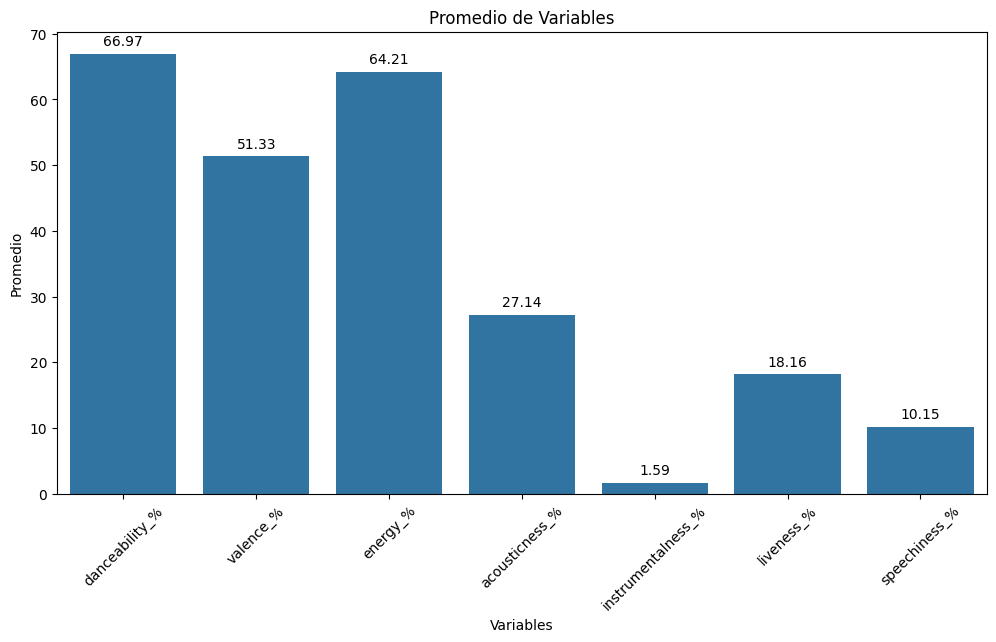

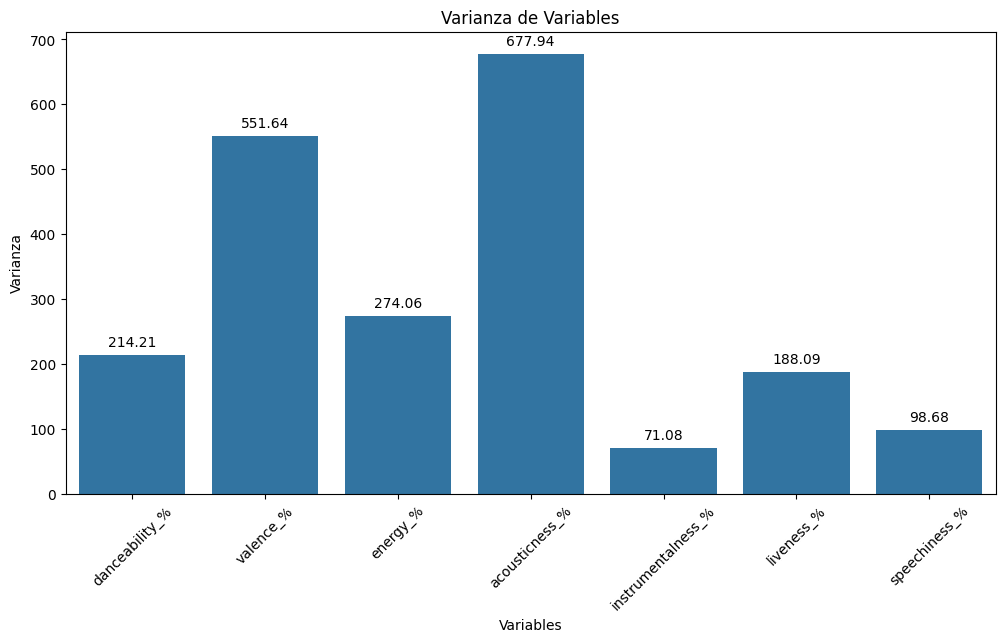

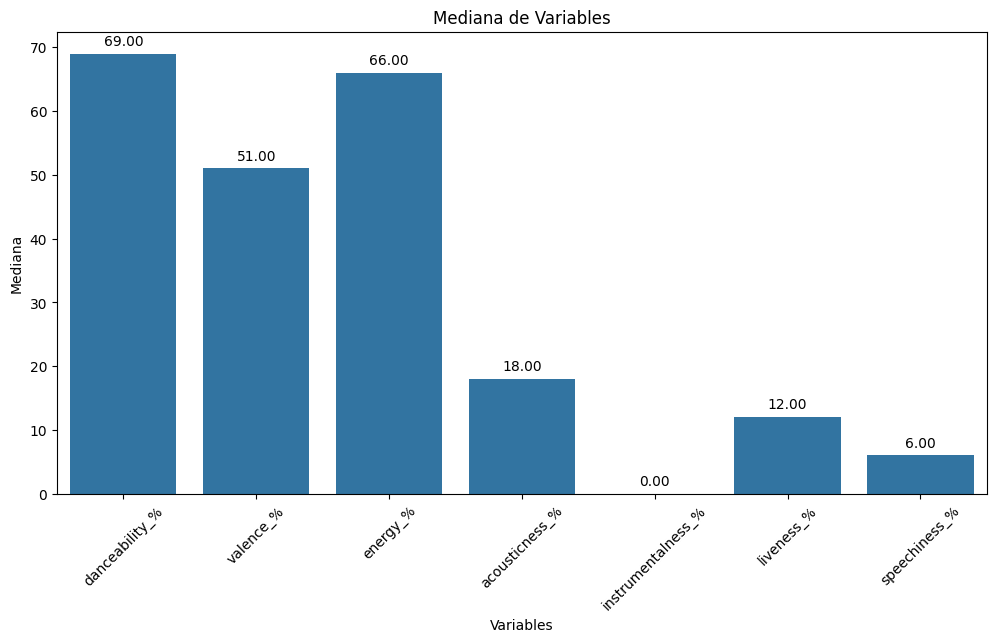

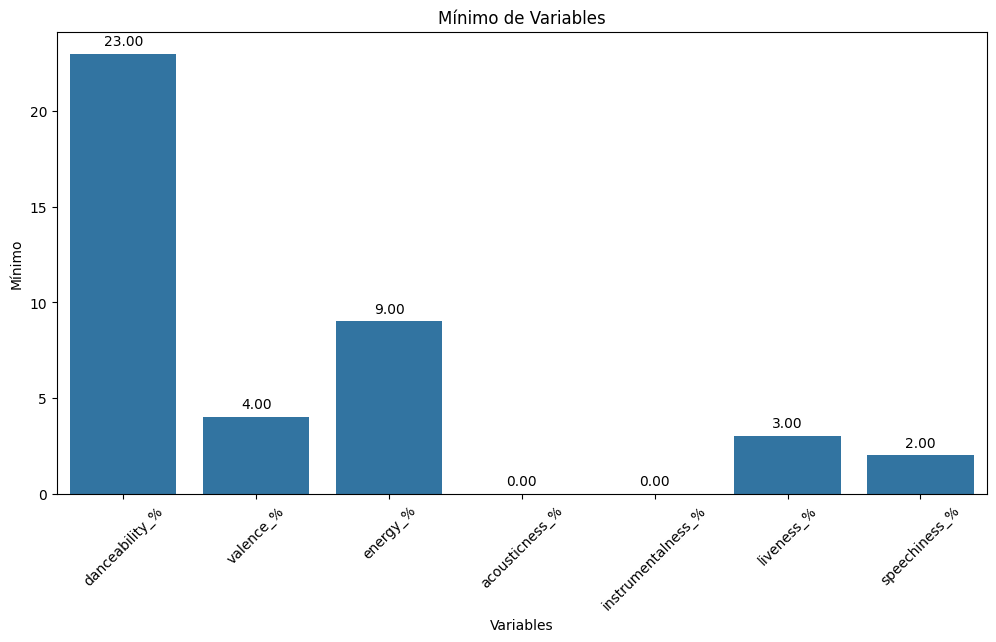

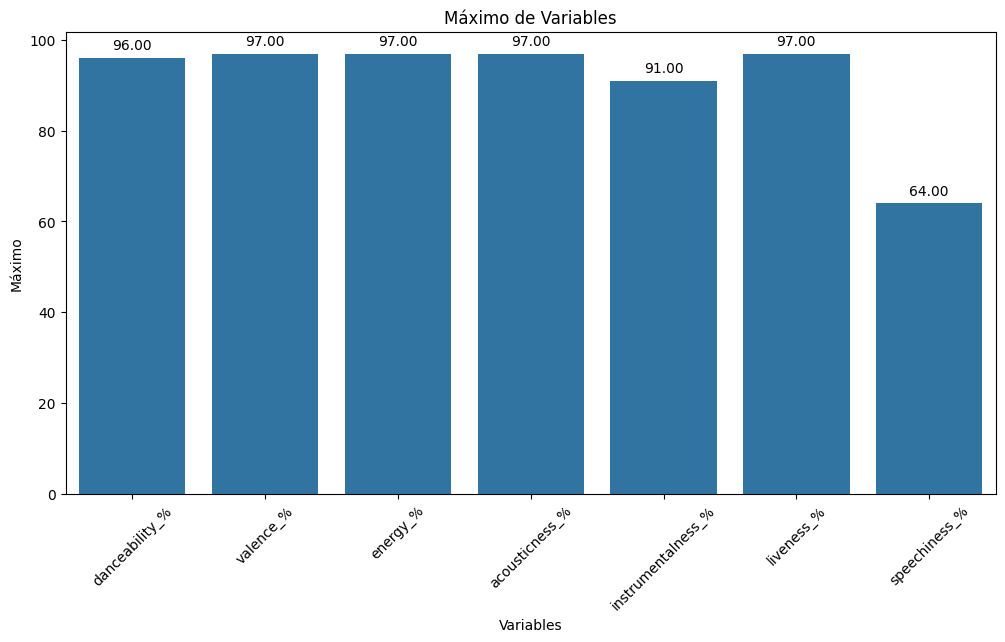

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

# Suponiendo que ya tienes df_cleaned con los datos cargados y limpios

# Definir las variables a calcular las m√©tricas (excluyendo 'streams', 'bpm' y 'participacion_total')
variables = ['danceability_%', 'valence_%', 'energy_%',
             'acousticness_%', 'instrumentalness_%', 'liveness_%', 'speechiness_%']

# Calcular m√©tricas estad√≠sticas para cada variable
summary_table = df_cleaned[variables].agg(['mean', 'median', 'std', 'var', 'min', 'max', 'count'])

# Transponer la tabla para una mejor visualizaci√≥n
summary_table = summary_table.T

# Renombrar columnas para mayor claridad
summary_table.columns = ['Promedio', 'Mediana', 'Desviaci√≥n Est√°ndar', 'Varianza', 'M√≠nimo', 'M√°ximo', 'N√∫mero de Elementos']

# Mostrar la tabla en un Jupyter Notebook
display(summary_table)

# Guardar la tabla en un archivo Excel
summary_table.to_excel("summary_statistics.xlsx", index=True)

# Crear gr√°ficos de barras para cada m√©trica
metrics = ['Promedio', 'Varianza', 'Mediana', 'Desviaci√≥n Est√°ndar', 'M√≠nimo', 'M√°ximo']

for metric in metrics:
    plt.figure(figsize=(12, 6))
    ax = sns.barplot(x=summary_table.index, y=summary_table[metric])
    plt.title(f'{metric} de Variables')
    plt.xlabel('Variables')
    plt.ylabel(metric)
    plt.xticks(rotation=45)

    # A√±adir etiquetas de datos
    for p in ax.patches:
        ax.annotate(format(p.get_height(), '.2f'),
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha = 'center', va = 'center',
                    xytext = (0, 9),
                    textcoords = 'offset points')

    plt.show()


## Hito 3

En este hito aplicar√°s la regresi√≥n linear para las mismas hip√≥tesis analizadas en el hito 1.

- [x]  Las canciones con un mayor BPM (Beats Por Minuto) tienen m√°s √©xito en t√©rminos de streams en Spotify
- [x]  Las canciones m√°s populares en el ranking de Spotify tambi√©n tienen un comportamiento similar en otras plataformas como Deezer
- [x]  La presencia de una canci√≥n en un mayor n√∫mero de playlists se relaciona con un mayor n√∫mero de streams
- [x]  Los artistas con un mayor n√∫mero de canciones en Spotify tienen m√°s streams
- [x]  Las caracter√≠sticas de la canci√≥n influyen en el √©xito en t√©rminos de streams en Spotify

---

Meta

üî¥ Regresi√≥n lineal	Entendimiento m√°s profundizado de la relaci√≥n lineal entre dos variables continuas

Cada una debe hacer al menos una vez este an√°lisis, por ejemplo una hace para streams por bpm y la otra streams por total_playlists.

Lo importante tambi√©n es discutir los resultados y explorar las otras variables.

‚ö†Ô∏è Para empezar, abstrae la idea de dividir la data en ‚Äúentrenamiento‚Äù y ‚Äútest‚Äù. Este concepto ser√° abordado con m√°s profundidad en los pr√≥ximos proyectos.

üé• Guia pr√°ctico de los pasos para ejecutar una regresi√≥n lineal simple en Python con el paquete sklearn..

üìÑ Tutorial pr√°ctico de los pasos para ejecutar (e interpretar) una regresi√≥n lineal simple en Python.

üßë‚ÄçüíªPide ayuda a Chat GPT para interpretar los resultados.

---

üü†representar datos a trav√©s de gr√°ficos o visuales avanzados	Crear un gr√°fico de dispersi√≥n (scatter plot) con la reta obtenida de la regresi√≥n linear simple.

Cada una debe hacer al menos una vez este gr√°fico, por ejemplo una hace para streams por bpm y la otra streams por total_playlists.

Lo importante tambi√©n es discutir los resultados y explorar las otras variables.

üé• Guia pr√°ctico de los pasos para ejecutar una regresi√≥n lineal simple en Python con el paquete sklearn.

üìÑ Tutorial pr√°ctico de los pasos para ejecutar (y interpretar) una regresi√≥n lineal simple en Python.

üìÑ Manual del paquete matplotlib./

üßë‚Äçüíª Pide a Chat GPT que te ayude con el c√≥digo para crear una scatterplot con el paquete matplotlib y agrega a ese gr√°fico la l√≠nea obtenida de la regresi√≥n lineal simple.

üßë‚Äçüíª Pide a Chat GPT que te ayude con el c√≥digo para ‚Äúcustomizar‚Äù tu gr√°fica. Cambia colores, nombres de los ejes, etc etc.

---

### Checklist

- [x]  ¬øHas aplicado la t√©cnica de regresi√≥n lineal simple (y la entendiste/interpretaste), al menos una vez?
- [x]  ¬øHas elaborado al menos un gr√°fico de dispersi√≥n (scatter plot) junto con la l√≠nea de regresi√≥n resultante?
- [x] ¬øHas discutido y seleccionado la informaci√≥n relevante para la presentaci√≥n en conjunto con tu dupla (si es que lo has hecho en dupla)?



In [ ]:
# Instalar scikit-learn si no est√° instalado
!pip install scikit-learn

# Importar las bibliotecas necesarias
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Suponiendo que ya tienes df_cleaned con los datos cargados y limpios

# Definir la variable dependiente (target) y la variable independiente (features)
X = df_cleaned[['bpm']]  # Variable independiente (BPM)
y = df_cleaned['streams']  # Variable dependiente (Streams)

# Dividir los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Crear un modelo de regresi√≥n lineal
model = LinearRegression()

# Entrenar el modelo con los datos de entrenamiento
model.fit(X_train, y_train)

# Hacer predicciones con los datos de prueba
y_pred = model.predict(X_test)

# Calcular el error cuadr√°tico medio (MSE) para evaluar el modelo
mse = mean_squared_error(y_test, y_pred)

# Mostrar los coeficientes del modelo y el error cuadr√°tico medio
print("Coeficientes del modelo:", model.coef_)
print("Intercepto del modelo:", model.intercept_)
print("Error cuadr√°tico medio (MSE):", mse)

# Configurar el estilo del gr√°fico
plt.figure(figsize=(10, 6))

# Graficar el scatter plot con c√≠rculos de borde y fondo transparente
plt.scatter(X_test, y_test, edgecolor='#cc0099', facecolor='none', label='Datos reales')

# Graficar la l√≠nea de regresi√≥n con etiqueta de datos
plt.plot(X_test, y_pred, color='red', linewidth=2, label='Regresi√≥n lineal')


# Configurar t√≠tulo y etiquetas de ejes
plt.title('Regresi√≥n lineal simple: Streams vs BPM')
plt.xlabel('BPM')
plt.ylabel('Streams')

# Mostrar la leyenda, cuadr√≠cula y ajustar el dise√±o
plt.legend()
plt.grid(True)
plt.tight_layout()

# Mostrar el gr√°fico
plt.show()


Coeficientes del modelo: [-100034.94960625]
Intercepto del modelo: 509771949.2442488
Error cuadr√°tico medio (MSE): 3.78954009523637e+17


In [ ]:
# Importar las bibliotecas necesarias
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Suponiendo que ya tienes df_cleaned con los datos cargados y limpios

# Filtrar datos para canciones populares en Spotify, Deezer y Apple
df_filtered = df_cleaned[
    np.logical_or.reduce([
        df_cleaned['in_spotify_charts'].astype(bool),
        df_cleaned['in_deezer_charts'].astype(bool),
        df_cleaned['in_apple_charts'].astype(bool)
    ])
]

# Configurar el tama√±o del gr√°fico
plt.figure(figsize=(10, 6))

# Scatter plot para Deezer Charts vs Spotify Charts
plt.scatter(df_filtered['in_spotify_charts'], df_filtered['in_deezer_charts'], color='blue', label='Deezer', alpha=0.7)

# Scatter plot para Apple Charts vs Spotify Charts
plt.scatter(df_filtered['in_spotify_charts'], df_filtered['in_apple_charts'], color='green', label='Apple', alpha=0.7)

# Scatter plot para Spotify Charts
plt.scatter(df_filtered['in_spotify_charts'], df_filtered['in_spotify_charts'], marker='o', s=80, color='red', label='Spotify', alpha=0.7)

# Configurar t√≠tulo y etiquetas de ejes
plt.title('Comparaci√≥n de Popularidad en Deezer y Apple respecto a Spotify Charts')
plt.xlabel('Spotify Charts')
plt.ylabel('Presencia en Charts (Deezer, Apple y Spotify)')
plt.xticks([0, 1], ['No', 'S√≠'])  # Cambiar etiquetas del eje x a 'No' y 'S√≠'

# Ajustar las posiciones de las etiquetas del eje x para mayor claridad
plt.gca().xaxis.set_ticks_position('none')
plt.gca().yaxis.set_ticks_position('none')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Mostrar la leyenda, cuadr√≠cula y ajustar el dise√±o
plt.legend()
plt.grid(True)
plt.tight_layout()

# Mostrar el gr√°fico de dispersi√≥n comparativo
plt.show()


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from scipy import stats

# Suponiendo que ya tienes df_cleaned con los datos cargados y limpios

# Filtrar datos para canciones populares en Spotify, Deezer y Apple
df_filtered = df_cleaned[
    np.logical_or.reduce([
        df_cleaned['in_spotify_charts'].astype(bool),
        df_cleaned['in_deezer_charts'].astype(bool),
        df_cleaned['in_apple_charts'].astype(bool)
    ])
]

# Seleccionar las variables de inter√©s
X = df_filtered['in_spotify_charts'].values.reshape(-1, 1).astype(float)  # Asegurando que X sea de tipo float
y_deezer = df_filtered['in_deezer_charts'].values.astype(float)  # Asegurando que y_deezer sea de tipo float
y_apple = df_filtered['in_apple_charts'].values.astype(float)  # Asegurando que y_apple sea de tipo float

# Crear modelo de regresi√≥n lineal para Deezer Charts vs Spotify Charts
model_deezer = LinearRegression()
model_deezer.fit(X, y_deezer)

# Predecir valores de Deezer Charts usando el modelo
y_deezer_pred = model_deezer.predict(X)

# Calcular el Error Cuadr√°tico Medio (MSE) para Deezer Charts
mse_deezer = mean_squared_error(y_deezer, y_deezer_pred)

# Crear modelo de regresi√≥n lineal para Apple Charts vs Spotify Charts
model_apple = LinearRegression()
model_apple.fit(X, y_apple)

# Predecir valores de Apple Charts usando el modelo
y_apple_pred = model_apple.predict(X)

# Calcular el Error Cuadr√°tico Medio (MSE) para Apple Charts
mse_apple = mean_squared_error(y_apple, y_apple_pred)

# Realizar pruebas estad√≠sticas

# Prueba de Shapiro-Wilk para Spotify Charts
sw_stat_spotify, sw_pvalue_spotify = stats.shapiro(X.flatten())
print(f"\nPrueba de Shapiro-Wilk para Spotify Charts:")
print(f"W-statistic: {sw_stat_spotify}, p-value: {sw_pvalue_spotify}")

# Test t de Student para Deezer Charts vs Spotify Charts
t_statistic_deezer, p_value_deezer = stats.ttest_ind(y_deezer, X.flatten(), equal_var=False)
print(f"\nTest t de Student para Deezer vs Spotify Charts:")
print(f"T-statistic: {t_statistic_deezer}, p-value: {p_value_deezer}")

# Test t de Student para Apple Charts vs Spotify Charts
t_statistic_apple, p_value_apple = stats.ttest_ind(y_apple, X.flatten(), equal_var=False)
print(f"\nTest t de Student para Apple vs Spotify Charts:")
print(f"T-statistic: {t_statistic_apple}, p-value: {p_value_apple}")

# Test de Wilcoxon-Mann-Whitney para Deezer Charts vs Spotify Charts
w_statistic_deezer, p_value_deezer_w = stats.mannwhitneyu(y_deezer, X.flatten())
print(f"\nTest de Wilcoxon-Mann-Whitney para Deezer vs Spotify Charts:")
print(f"U-statistic: {w_statistic_deezer}, p-value: {p_value_deezer_w}")

# Test de Wilcoxon-Mann-Whitney para Apple Charts vs Spotify Charts
w_statistic_apple, p_value_apple_w = stats.mannwhitneyu(y_apple, X.flatten())
print(f"\nTest de Wilcoxon-Mann-Whitney para Apple vs Spotify Charts:")
print(f"U-statistic: {w_statistic_apple}, p-value: {p_value_apple_w}")

# Configurar el tama√±o del gr√°fico
plt.figure(figsize=(10, 6))

# Scatter plot para Deezer Charts vs Spotify Charts
colors_deezer = ['#228B22' if y else '#87CEEB' for y in df_filtered['in_deezer_charts'].astype(bool)]
plt.scatter(X, y_deezer, color=colors_deezer, label='Deezer', alpha=0.7)

# Scatter plot para Apple Charts vs Spotify Charts
colors_apple = ['black' if y else 'white' for y in df_filtered['in_apple_charts'].astype(bool)]
plt.scatter(X, y_apple, color=colors_apple, label='Apple', alpha=0.7, edgecolors='black')

# Regresi√≥n lineal para Deezer Charts vs Spotify Charts
plt.plot(X, model_deezer.predict(X), color='blue', linewidth=2, label='Regresi√≥n Deezer')

# Regresi√≥n lineal para Apple Charts vs Spotify Charts
plt.plot(X, model_apple.predict(X), color='black', linewidth=2, label='Regresi√≥n Apple')

# Configurar t√≠tulo y etiquetas de ejes
plt.title('Regresi√≥n Lineal de Deezer y Apple respecto a Spotify Charts')
plt.xlabel('Spotify Charts')
plt.ylabel('Presencia en Charts (Deezer y Apple)')
plt.xticks([0, 1], ['No', 'S√≠'])  # Cambiar etiquetas del eje x a 'No' y 'S√≠'

# Ajustar las posiciones de las etiquetas del eje x para mayor claridad
plt.gca().xaxis.set_ticks_position('none')
plt.gca().yaxis.set_ticks_position('none')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Mostrar la leyenda, cuadr√≠cula y ajustar el dise√±o
plt.legend()
plt.grid(True)
plt.tight_layout()

# Mostrar el gr√°fico de dispersi√≥n comparativo con regresi√≥n lineal
plt.show()

# Mostrar el MSE para Deezer y Apple
print("\nError Cuadr√°tico Medio (MSE):")
print(f"Deezer vs Spotify: {mse_deezer:.2f}")
print(f"Apple vs Spotify: {mse_apple:.2f}")

# Explicaci√≥n del gr√°fico:
print("\nExplicaci√≥n del gr√°fico:")
print("- La l√≠nea azul ('Regresi√≥n Deezer') representa la tendencia de c√≥mo las canciones populares en Deezer")
print("  se comportan en relaci√≥n con Spotify Charts. Si la l√≠nea sube, indica una correlaci√≥n positiva.")
print("- La l√≠nea negra ('Regresi√≥n Apple') muestra la relaci√≥n entre las canciones populares en Apple Music")
print("  y Spotify Charts. Su inclinaci√≥n indica la direcci√≥n de la relaci√≥n: hacia arriba significa correlaci√≥n positiva,")
print("  hacia abajo significa correlaci√≥n negativa.")
print("- Los c√≠rculos verdes oscuros representan las canciones populares en Deezer. Los c√≠rculos celestes indican ausencia")
print("  en los charts de Spotify.")
print("- Los c√≠rculos blancos con borde negro representan las canciones populares en Apple Music. Los c√≠rculos rellenos de negro")
print("  indican ausencia en los charts de Spotify, mientras que los c√≠rculos blancos indican presencia.")



Prueba de Shapiro-Wilk para Spotify Charts:
W-statistic: 0.6869614720344543, p-value: 1.6415153248964974e-37

Test t de Student para Deezer vs Spotify Charts:
T-statistic: -14.264810631405497, p-value: 2.486799167406407e-42

Test t de Student para Apple vs Spotify Charts:
T-statistic: 23.435564295372654, p-value: 1.1223952978245818e-99

Test de Wilcoxon-Mann-Whitney para Deezer vs Spotify Charts:
U-statistic: 263284.0, p-value: 4.150186927427789e-36

Test de Wilcoxon-Mann-Whitney para Apple vs Spotify Charts:
U-statistic: 628814.0, p-value: 4.662872441105302e-110



Error Cuadr√°tico Medio (MSE):
Deezer vs Spotify: 24.59
Apple vs Spotify: 1815.13

Explicaci√≥n del gr√°fico:
- La l√≠nea azul ('Regresi√≥n Deezer') representa la tendencia de c√≥mo las canciones populares en Deezer
  se comportan en relaci√≥n con Spotify Charts. Si la l√≠nea sube, indica una correlaci√≥n positiva.
- La l√≠nea negra ('Regresi√≥n Apple') muestra la relaci√≥n entre las canciones populares en Apple Music
  y Spotify Charts. Su inclinaci√≥n indica la direcci√≥n de la relaci√≥n: hacia arriba significa correlaci√≥n positiva,
  hacia abajo significa correlaci√≥n negativa.
- Los c√≠rculos verdes oscuros representan las canciones populares en Deezer. Los c√≠rculos celestes indican ausencia
  en los charts de Spotify.
- Los c√≠rculos blancos con borde negro representan las canciones populares en Apple Music. Los c√≠rculos rellenos de negro
  indican ausencia en los charts de Spotify, mientras que los c√≠rculos blancos indican presencia.


### Deezer
los circulos, verdes pastel para si

celeste para no.

con la linea de regresion azul fuerte

### Apple
Si - circulito blanco de borde negro

No - sea el relleno negro

con la linea de regresion negra.

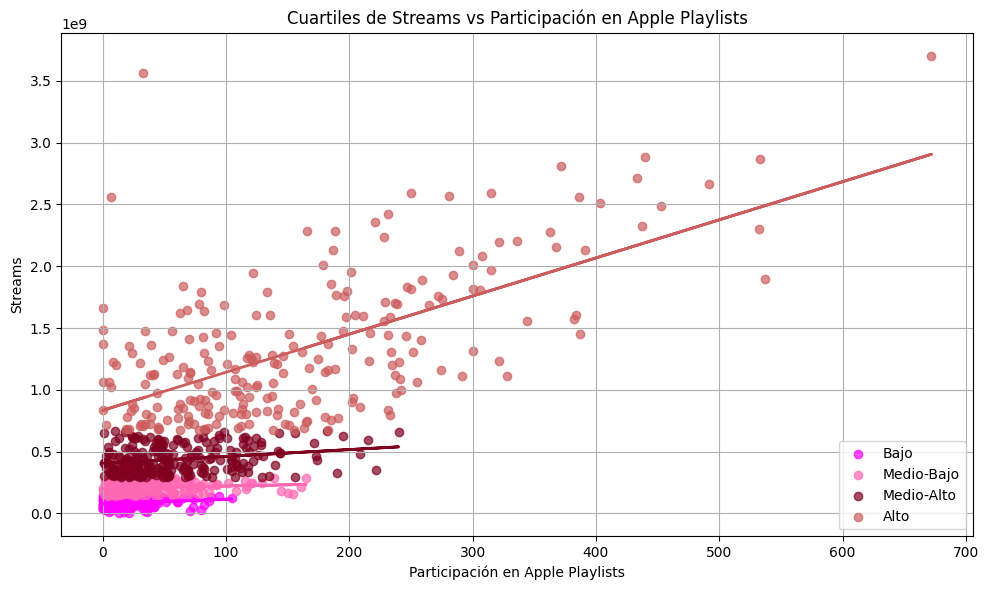


Prueba de Shapiro-Wilk para participacion_total:
W-statistic: 0.604838490486145, p-value: 6.31565217871195e-42

Test t de Student para participacion_total vs streams:
T-statistic: -27.881713972523993, p-value: 2.1923200493039067e-125
Error en la prueba de Wilcoxon-Mann-Whitney para participacion_total vs streams: `x` and `y` must be of nonzero size.

Prueba de Shapiro-Wilk para in_apple_playlists:
W-statistic: 0.7207379341125488, p-value: 5.0567045628336314e-37

Test t de Student para in_apple_playlists vs streams:
T-statistic: -27.8816772657557, p-value: 2.1935541822706083e-125

Test de Wilcoxon-Mann-Whitney para in_apple_playlists vs streams:
U-statistic: 145.0, p-value: 0.3671889398783247

Prueba de Shapiro-Wilk para in_deezer_playlists:
W-statistic: 0.3625755310058594, p-value: 0.0

Test t de Student para in_deezer_playlists vs streams:
T-statistic: -27.8816899807524, p-value: 2.1931266076625477e-125

Test de Wilcoxon-Mann-Whitney para in_deezer_playlists vs streams:
U-statistic: 

In [50]:
# Importar las bibliotecas necesarias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from scipy import stats

# Suponiendo que ya tienes df_cleaned con los datos cargados y limpios

# Filtrar datos para canciones populares en Spotify, Deezer y Apple
df_filtered = df_cleaned[
    np.logical_or.reduce([
        df_cleaned['in_spotify_playlists'].astype(bool),
        df_cleaned['in_deezer_playlists'].astype(bool),
        df_cleaned['in_apple_playlists'].astype(bool)
    ])
]

# Asegurarse de que las columnas de inter√©s sean num√©ricas y sin valores nulos
df_filtered = df_filtered[['participacion_total', 'streams', 'in_spotify_playlists', 'in_deezer_playlists', 'in_apple_playlists']].apply(pd.to_numeric, errors='coerce').dropna()

# Definir los cuartiles para la columna de streams
df_filtered['cuartiles_streams'] = pd.qcut(df_filtered['streams'], q=4, labels=['Bajo', 'Medio-Bajo', 'Medio-Alto', 'Alto'])

# Colores personalizados para los gr√°ficos
colors = {
    'Bajo': '#FF00FF',       # Fucsia
    'Medio-Bajo': '#FF69B4', # Rosado
    'Medio-Alto': '#800020', # Vinotinto
    'Alto': '#CD5C5C'        # Caf√© rojizo claro
}

# Gr√°ficos para cuartiles de streams vs participacion_total y participaci√≥n en playlists
def plot_comparison(df, x_col, y_col, xlabel, ylabel, title):
    plt.figure(figsize=(10, 6))
    for cuartil, group in df.groupby('cuartiles_streams'):
        plt.scatter(group[x_col], group[y_col], label=cuartil, alpha=0.7, color=colors[cuartil])

        # Crear modelo de regresi√≥n lineal
        X = group[x_col].values.reshape(-1, 1)
        y = group[y_col].values
        model = LinearRegression()
        model.fit(X, y)
        y_pred = model.predict(X)

        # Graficar la l√≠nea de regresi√≥n
        plt.plot(X, y_pred, color=colors[cuartil], linewidth=2)

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Gr√°fico para cuartiles de streams vs participacion_total
plot_comparison(df_filtered, 'participacion_total', 'streams', 'Participaci√≥n Total', 'Streams', 'Cuartiles de Streams vs Participaci√≥n Total')

# Gr√°fico para cuartiles de streams vs participacion en Apple Playlists
plot_comparison(df_filtered, 'in_apple_playlists', 'streams', 'Participaci√≥n en Apple Playlists', 'Streams', 'Cuartiles de Streams vs Participaci√≥n en Apple Playlists')

# Gr√°fico para cuartiles de streams vs participacion en Spotify Playlists
plot_comparison(df_filtered, 'in_spotify_playlists', 'streams', 'Participaci√≥n en Spotify Playlists', 'Streams', 'Cuartiles de Streams vs Participaci√≥n en Spotify Playlists')

# Gr√°fico para cuartiles de streams vs participacion en Deezer Playlists
plot_comparison(df_filtered, 'in_deezer_playlists', 'streams', 'Participaci√≥n en Deezer Playlists', 'Streams', 'Cuartiles de Streams vs Participaci√≥n en Deezer Playlists')

# Funci√≥n para realizar las pruebas de Shapiro-Wilk, t de Student y Wilcoxon-Mann-Whitney
def perform_tests(df, x_col, y_col):
    X = df[x_col].to_numpy().reshape(-1, 1)
    y = df[y_col].to_numpy()

    # Prueba de Shapiro-Wilk
    sw_stat, sw_pvalue = stats.shapiro(X.flatten())
    print(f"\nPrueba de Shapiro-Wilk para {x_col}:")
    print(f"W-statistic: {sw_stat}, p-value: {sw_pvalue}")

    # Prueba t de Student
    t_stat, t_pvalue = stats.ttest_rel(X.flatten(), y)
    print(f"\nTest t de Student para {x_col} vs {y_col}:")
    print(f"T-statistic: {t_stat}, p-value: {t_pvalue}")

    # Prueba de Wilcoxon-Mann-Whitney
    try:
        u_stat, u_pvalue = stats.mannwhitneyu(df[df[x_col] == 1][y_col], df[df[x_col] == 0][y_col])
        print(f"\nTest de Wilcoxon-Mann-Whitney para {x_col} vs {y_col}:")
        print(f"U-statistic: {u_stat}, p-value: {u_pvalue}")
    except ValueError as e:
        print(f"Error en la prueba de Wilcoxon-Mann-Whitney para {x_col} vs {y_col}: {e}")

# Realizar pruebas para participacion_total
perform_tests(df_filtered, 'participacion_total', 'streams')

# Realizar pruebas para in_apple_playlists
perform_tests(df_filtered, 'in_apple_playlists', 'streams')

# Realizar pruebas para in_deezer_playlists
perform_tests(df_filtered, 'in_deezer_playlists', 'streams')

# Explicaci√≥n del gr√°fico:
print("\nExplicaci√≥n del gr√°fico:")
print("- La l√≠nea fucsia representa la regresi√≥n lineal de las canciones en Deezer y Apple Music en relaci√≥n con el n√∫mero de streams.")
print("- Los c√≠rculos vinotinto representan las canciones populares en Deezer.")
print("- Los c√≠rculos de caf√© rojizo claro representan las canciones populares en Apple Music.")
print("- La inclinaci√≥n de las l√≠neas indica la direcci√≥n de la relaci√≥n entre participaci√≥n total y streams: hacia arriba significa una correlaci√≥n positiva, mientras que hacia abajo indica una correlaci√≥n negativa.")


La presencia de una canci√≥n en un mayor n√∫mero de playlists se relaciona con un mayor n√∫mero de streams

 Los artistas con un mayor n√∫mero de canciones en Spotify tienen m√°s streams

 Las caracter√≠sticas de la canci√≥n influyen en el √©xito en t√©rminos de streams en Spotify

In [123]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Suponiendo que ya tienes df_cleaned con los datos cargados y limpios

# Convertir 'streams' a num√©rico, ignorando errores
df_cleaned['streams'] = pd.to_numeric(df_cleaned['streams'], errors='coerce')

# Eliminar filas con NaNs en 'streams'
df_cleaned.dropna(subset=['streams'], inplace=True)

# Agrupar por artista y sumar los streams de todos los tracks de cada artista
artist_streams = df_cleaned.groupby('artist_s_name')['streams'].sum().reset_index()

# Verificar que no haya NaNs en 'streams'
if artist_streams['streams'].isnull().any():
    raise ValueError("Existen NaNs en 'streams'. Revisa tus datos.")

# Agrupar artistas en bloques de 10
artist_streams['artist_group'] = pd.cut(artist_streams.index, bins=np.arange(0, len(artist_streams) + 10, 10), labels=False)

# Calcular la suma de streams por cada grupo de artistas
grouped_artist_streams = artist_streams.groupby('artist_group')['streams'].sum().reset_index()

# Crear una secuencia num√©rica para representar cada grupo de artistas de manera √∫nica
group_indices = np.arange(len(grouped_artist_streams))

# Seleccionar las variables de inter√©s para la regresi√≥n lineal
X_artist = group_indices.reshape(-1, 1)
y_streams_artist = grouped_artist_streams['streams'].values

# Crear modelo de regresi√≥n lineal
model_artist = LinearRegression()
model_artist.fit(X_artist, y_streams_artist)

# Predecir valores de streams usando el modelo
y_streams_pred_artist = model_artist.predict(X_artist)

# Calcular el Error Cuadr√°tico Medio (MSE)
mse_artist = mean_squared_error(y_streams_artist, y_streams_pred_artist)

# Configurar el tama√±o del gr√°fico
plt.figure(figsize=(10, 6))

# Scatter plot para Suma de Streams por Grupo de Artistas vs Grupos de Artistas
plt.scatter(group_indices, grouped_artist_streams['streams'] / 1e6, color='#FF5733', label='Datos', alpha=0.7)

# Regresi√≥n lineal para Suma de Streams por Grupo de Artistas vs Grupos de Artistas
plt.plot(group_indices, y_streams_pred_artist / 1e6, color='#FF5733', linewidth=2, label='Regresi√≥n Lineal')

# Configurar t√≠tulo y etiquetas de ejes
plt.title('Regresi√≥n Lineal de Suma de Streams por Grupo de Artistas vs Grupos de Artistas')
plt.xlabel('Grupos de Artistas (de 10 en 10)')
plt.ylabel('Total de Streams (Millones)')

# Ajustar las posiciones de las etiquetas del eje x para mayor claridad
plt.gca().xaxis.set_ticks_position('none')
plt.gca().yaxis.set_ticks_position('none')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Mostrar la leyenda, cuadr√≠cula y ajustar el dise√±o
plt.legend()
plt.grid(True)
plt.tight_layout()

# Mostrar el gr√°fico de dispersi√≥n comparativo con regresi√≥n lineal
plt.show()

# Mostrar el MSE
print("\nError Cuadr√°tico Medio (MSE):")
print(f"Suma de Streams por Grupo de Artistas vs Grupos de Artistas: {mse_artist:.2f}")

# Explicaci√≥n del gr√°fico:
print("\nExplicaci√≥n del gr√°fico:")
print("- La l√≠nea naranja ('Regresi√≥n Lineal') representa la tendencia de c√≥mo la suma de streams")
print("  por grupo de artistas afecta al total de streams.")
print("- Los puntos representan los datos observados de la suma de streams por grupo de artistas en relaci√≥n con")
print("  el total de streams, expresados en millones.")



Error Cuadr√°tico Medio (MSE):
Suma de Streams por Grupo de Artistas vs Grupos de Artistas: 25546640939085885440.00

Explicaci√≥n del gr√°fico:
- La l√≠nea naranja ('Regresi√≥n Lineal') representa la tendencia de c√≥mo la suma de streams
  por grupo de artistas afecta al total de streams.
- Los puntos representan los datos observados de la suma de streams por grupo de artistas en relaci√≥n con
  el total de streams, expresados en millones.


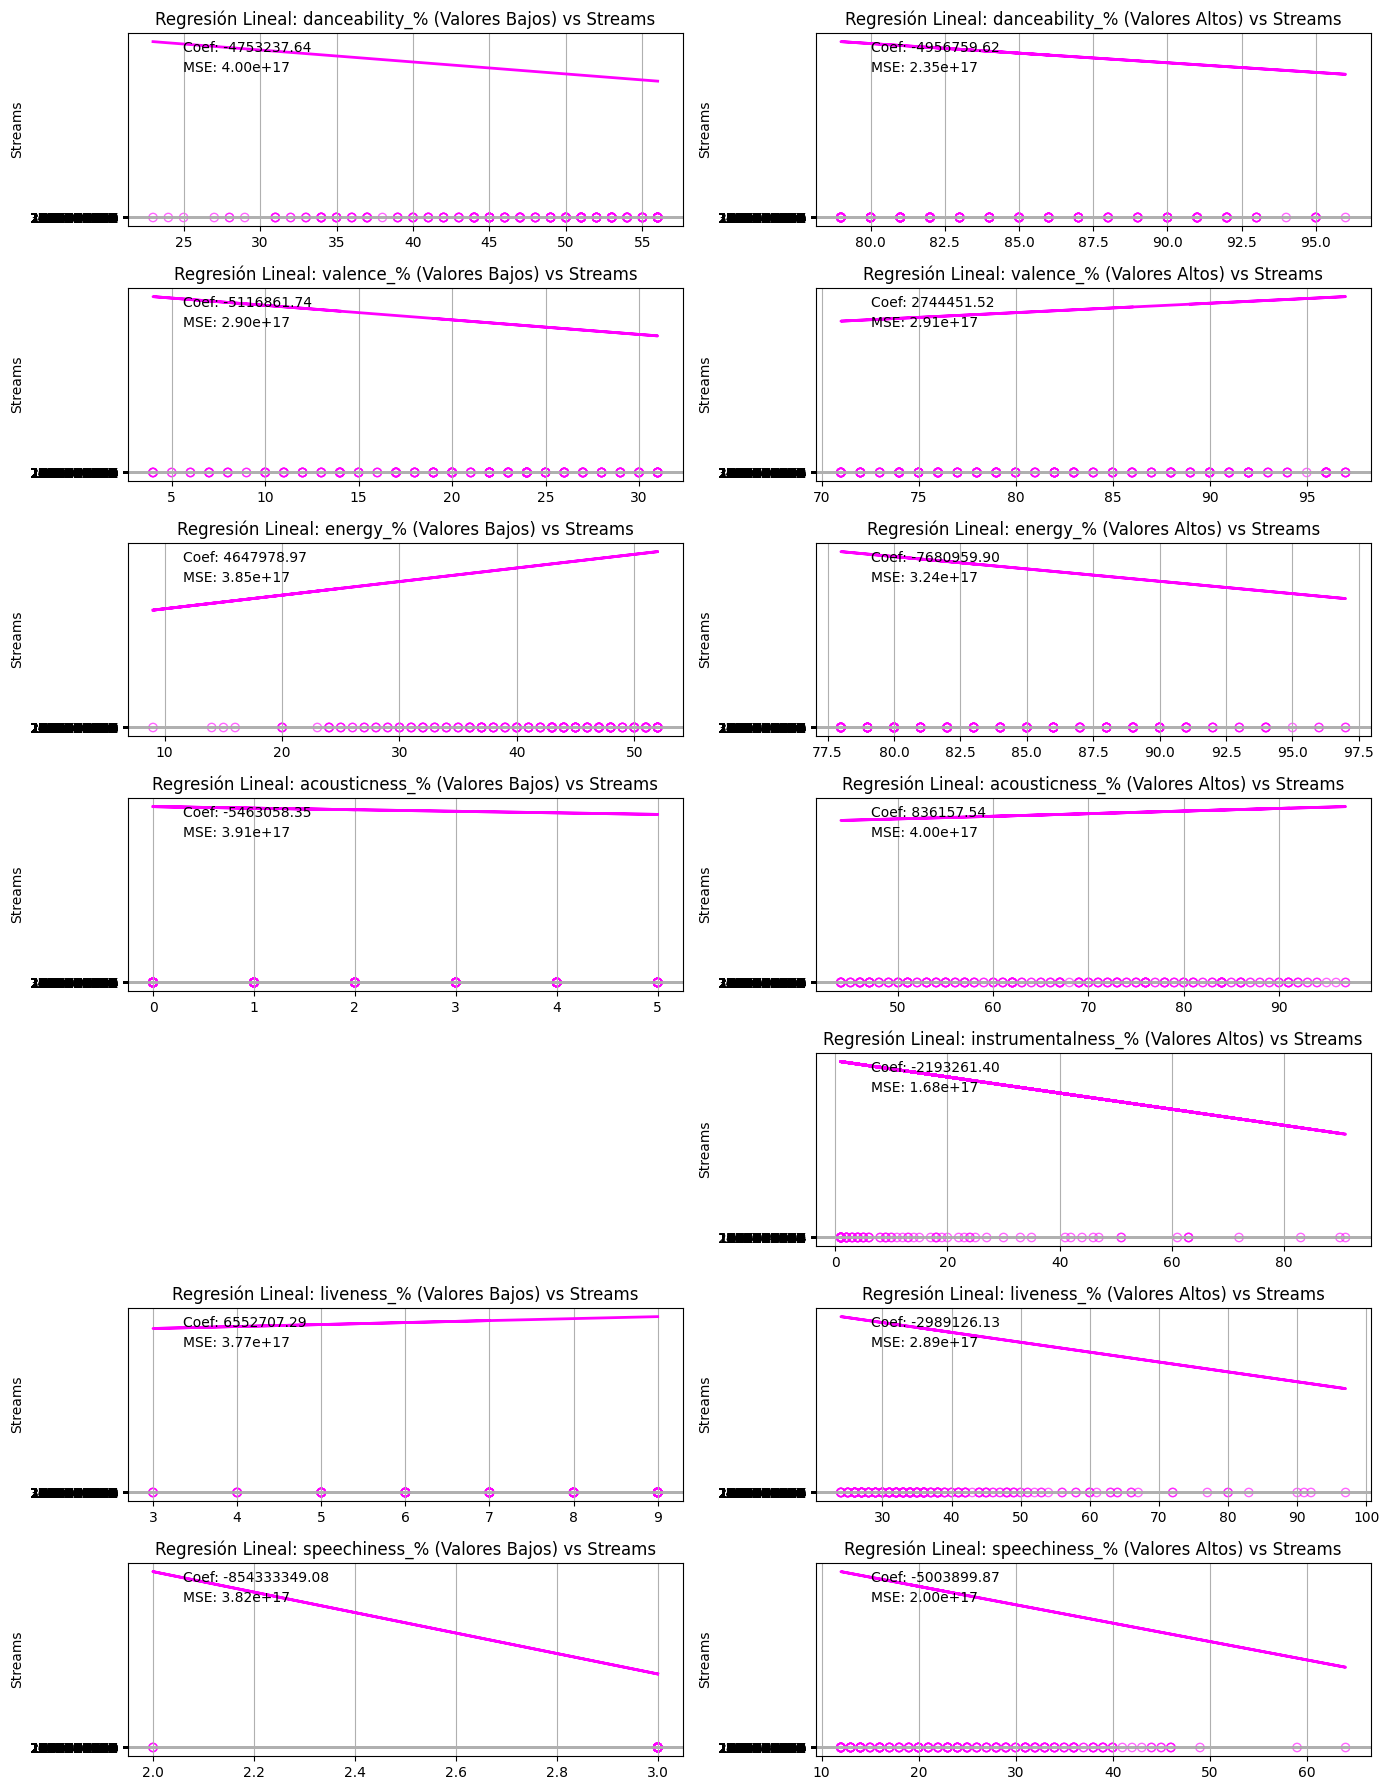

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Suponiendo que ya tienes df_cleaned con los datos cargados y limpios

# Definir las variables de inter√©s
features = ['danceability_%', 'valence_%', 'energy_%', 'acousticness_%',
            'instrumentalness_%', 'liveness_%', 'speechiness_%']
X = df_cleaned[features].values
y = df_cleaned['streams'].values

# Inicializar listas para almacenar resultados
coefficients = []
mse_scores = []

# Configurar el tama√±o del gr√°fico
plt.figure(figsize=(14, 18))

# Funci√≥n para convertir valores RGB de 0-255 a 0-1
def rgb_norm(rgb_tuple):
    return tuple(np.array(rgb_tuple) / 255)

# Iterar sobre cada caracter√≠stica y ajustar un modelo de regresi√≥n lineal
for i, feature in enumerate(features):
    # Calcular los percentiles 25 y 75 para dividir en valores bajos y altos
    low_threshold = np.percentile(df_cleaned[feature], 25)
    high_threshold = np.percentile(df_cleaned[feature], 75)

    # Filtrar los datos en valores bajos y altos
    low_data = df_cleaned[df_cleaned[feature] < low_threshold]
    high_data = df_cleaned[df_cleaned[feature] > high_threshold]

    # Aplicar transformaci√≥n logar√≠tmica solo si los datos de 'streams' son num√©ricos
    if pd.api.types.is_numeric_dtype(low_data['streams']):
        low_data['streams'] = np.log1p(low_data['streams'])

    if pd.api.types.is_numeric_dtype(high_data['streams']):
        high_data['streams'] = np.log1p(high_data['streams'])

    # Verificar si hay datos disponibles para valores bajos y altos
    if not low_data.empty:
        # Configurar subplots para valores bajos
        plt.subplot(7, 2, 2*i+1)
        model_low = LinearRegression()
        model_low.fit(low_data[[feature]], low_data['streams'])
        y_pred_low = model_low.predict(low_data[[feature]])
        plt.scatter(low_data[feature], low_data['streams'], edgecolor=rgb_norm((255, 0, 255)), facecolor='none', alpha=0.6)
        plt.plot(low_data[feature], y_pred_low, color=rgb_norm((255, 0, 255)), linewidth=2)
        plt.title(f'Regresi√≥n Lineal: {feature} (Valores Bajos) vs Streams')
        plt.ylabel('Streams')
        plt.grid(True)
        plt.text(0.1, 0.9, f'Coef: {model_low.coef_[0]:.2f}', transform=plt.gca().transAxes)
        mse_low = mean_squared_error(low_data['streams'], y_pred_low)
        plt.text(0.1, 0.8, f'MSE: {mse_low:.2e}', transform=plt.gca().transAxes)

        # Guardar coeficientes y MSE para valores bajos
        coefficients.append((model_low.coef_[0], None))  # None para valores altos
        mse_scores.append((mse_low, None))  # None para valores altos

    if not high_data.empty:
        # Configurar subplots para valores altos
        plt.subplot(7, 2, 2*i+2)
        model_high = LinearRegression()
        model_high.fit(high_data[[feature]], high_data['streams'])
        y_pred_high = model_high.predict(high_data[[feature]])
        plt.scatter(high_data[feature], high_data['streams'], edgecolor=rgb_norm((255, 0, 255)), facecolor='none', alpha=0.6)
        plt.plot(high_data[feature], y_pred_high, color=rgb_norm((255, 0, 255)), linewidth=2)
        plt.title(f'Regresi√≥n Lineal: {feature} (Valores Altos) vs Streams')
        plt.ylabel('Streams')
        plt.grid(True)
        plt.text(0.1, 0.9, f'Coef: {model_high.coef_[0]:.2f}', transform=plt.gca().transAxes)
        mse_high = mean_squared_error(high_data['streams'], y_pred_high)
        plt.text(0.1, 0.8, f'MSE: {mse_high:.2e}', transform=plt.gca().transAxes)

        # Actualizar coeficientes y MSE para valores altos
        if i < len(coefficients):
            coefficients[i] = (coefficients[i][0], model_high.coef_[0])
            mse_scores[i] = (mse_scores[i][0], mse_high)
        else:
            coefficients.append((None, model_high.coef_[0]))
            mse_scores.append((None, mse_high))

# Ajustar el dise√±o del gr√°fico general
plt.tight_layout()

# Mostrar los gr√°ficos
plt.show()

# Comparar los resultados de los coeficientes y MSE
print("Resumen:")
for i, feature in enumerate(features):
    print(f"Caracter√≠stica: {feature}")
    if coefficients[i][0] is not None:
        print(f"Coeficiente de regresi√≥n (Valores Bajos): {coefficients[i][0]:.2f}")
        print(f"MSE (Valores Bajos): {mse_scores[i][0]:.2e}")
    else:
        print("No hay suficientes datos para valores bajos.")

    if coefficients[i][1] is not None:
        print(f"Coeficiente de regresi√≥n (Valores Altos): {coefficients[i][1]:.2f}")
        print(f"MSE (Valores Altos): {mse_scores[i][1]:.2e}")
    else:
        print("No hay suficientes datos para valores altos.")

    print("--------------------------------------")


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Definir los nombres de los cuartiles
cuartiles_dict = {4: 'Alto', 3: 'Medio-Alto', 2: 'Medio-Bajo', 1: 'Bajo'}
df_cleaned['cuartiles_categoria'] = df_cleaned['cuartiles_streams'].map(cuartiles_dict)

# Crear una tabla pivot para el heatmap con mode
pivot_table_mode = df_cleaned.pivot_table(index='cuartiles_categoria', columns='mode', values='track_id', aggfunc='count', fill_value=0)

# Crear una tabla pivot para el heatmap con modo de canci√≥n
pivot_table_modocancion = df_cleaned.pivot_table(index='cuartiles_categoria', columns='modo_cancion', values='track_id', aggfunc='count', fill_value=0)

# Configurar tama√±o de la figura
plt.figure(figsize=(15, 8))

# Primer heatmap para mode
plt.subplot(1, 2, 1)
sns.heatmap(pivot_table_mode, annot=True, fmt="d", cmap="YlGnBu")
plt.title('Distribuci√≥n de Tracks por Mode y Cuartiles de Streams')
plt.xlabel('Mode')
plt.ylabel('Cuartiles de Streams')

# Segundo heatmap para modo de canci√≥n
plt.subplot(1, 2, 2)
sns.heatmap(pivot_table_modocancion, annot=True, fmt="d", cmap="YlGnBu")
plt.title('Distribuci√≥n de Tracks por Modo de Canci√≥n y Cuartiles de Streams')
plt.xlabel('Modo de Canci√≥n')
plt.ylabel('Cuartiles de Streams')

# Ajustar espaciado y mostrar la figura
plt.tight_layout()
plt.show()


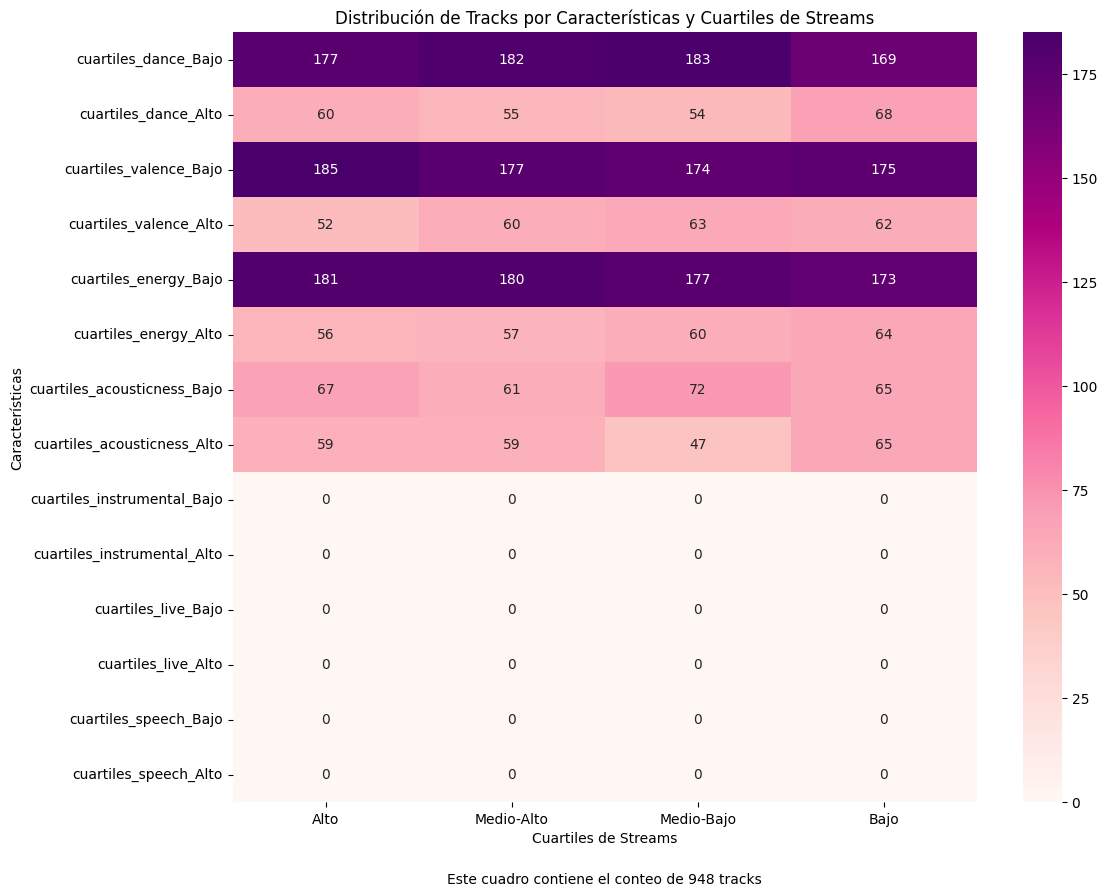

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Supongamos que ya tienes df_cleaned con los datos cargados y limpios

# Definir nombres y orden de cuartiles para streams y caracter√≠sticas
cuartiles_dict = {4: 'Alto', 3: 'Medio-Alto', 2: 'Medio-Bajo', 1: 'Bajo'}
cuartiles_features_order = {
    'cuartiles_dance': ['Bajo', 'Alto'],
    'cuartiles_valence': ['Bajo', 'Alto'],
    'cuartiles_energy': ['Bajo', 'Alto'],
    'cuartiles_acousticness': ['Bajo', 'Alto'],
    'cuartiles_instrumental': ['Bajo', 'Alto'],
    'cuartiles_live': ['Bajo', 'Alto'],
    'cuartiles_speech': ['Bajo', 'Alto']
}

# Funci√≥n para contar tracks por combinaci√≥n de caracter√≠sticas y cuartiles de streams
def count_tracks(df, feature, cuartile):
    counts = {}
    for cuartile_value in cuartiles_features_order[feature]:
        counts[cuartile_value] = df[(df['cuartiles_streams'] == cuartile) & (df[feature] == cuartile_value)].shape[0]
    return counts

# Crear DataFrame para el heatmap
heatmap_data = pd.DataFrame()

# Generar los datos para el heatmap
for feature, cuartiles in cuartiles_features_order.items():
    for cuartile in cuartiles_dict.keys():
        count = count_tracks(df_cleaned, feature, cuartile)
        for cuartile_value in cuartiles:
            heatmap_data.loc[f"{feature}_{cuartile_value}", cuartiles_dict[cuartile]] = count.get(cuartile_value, 0)

# Crear el heatmap usando seaborn
plt.figure(figsize=(12, 10))
sns.heatmap(heatmap_data, annot=True, fmt=".0f", cmap=sns.color_palette("RdPu", as_cmap=True))
plt.title('Distribuci√≥n de Tracks por Caracter√≠sticas y Cuartiles de Streams')
plt.xlabel('Cuartiles de Streams')
plt.ylabel('Caracter√≠sticas')

# Agregar texto con el conteo de tracks
plt.text(0.5, -0.1, f"Este cuadro contiene el conteo de {df_cleaned.shape[0]} tracks",
         horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
plt.savefig('heatmap_tracks_count.jpg', dpi=300, bbox_inches='tight')
plt.show()


In [ ]:
import pandas as pd
from scipy import stats

# Datos de promedios por cuartiles de categor√≠a para bpm y streams
promedios = pd.DataFrame({
    'cuartiles_categoria': ['Alto', 'Bajo', 'Medio-Alto', 'Medio-Bajo'],
    'bpm': [123.240506, 120.860759, 120.915612, 124.978903],
    'streams': [454339300.0, 600168900.0, 373394900.0, 628908500.0]
})

# Calcular el promedio de bpm por cuartiles_categoria
promedios_bpm = promedios.groupby('cuartiles_categoria')['bpm'].mean().reset_index()
print("Promedios por cuartiles de categor√≠a para bpm:")
print(promedios_bpm)

# Calcular el promedio de streams por cuartiles_categoria
promedios_streams = promedios.groupby('cuartiles_categoria')['streams'].mean().reset_index()
print("\nPromedios por cuartiles de categor√≠a para streams:")
print(promedios_streams)

# Obtener datos para las pruebas de hip√≥tesis
bpm_alto = promedios.loc[promedios['cuartiles_categoria'] == 'Alto', 'bpm']
bpm_bajo = promedios.loc[promedios['cuartiles_categoria'] == 'Bajo', 'bpm']
bpm_medio_alto = promedios.loc[promedios['cuartiles_categoria'] == 'Medio-Alto', 'bpm']
bpm_medio_bajo = promedios.loc[promedios['cuartiles_categoria'] == 'Medio-Bajo', 'bpm']

# Realizar pruebas de hip√≥tesis
# Test t de Student para bpm entre cuartiles Alto y Bajo
t_statistic_bpm_ab, p_value_bpm_ab = stats.ttest_ind(bpm_alto, bpm_bajo, equal_var=False)
print(f"\nPara cuartiles de categor√≠a Alto y Bajo:")
print(f"T-statistic (bpm): {t_statistic_bpm_ab}, p-value (bpm): {p_value_bpm_ab}")

# Test t de Student para bpm entre cuartiles Medio-Alto y Medio-Bajo
t_statistic_bpm_mm, p_value_bpm_mm = stats.ttest_ind(bpm_medio_alto, bpm_medio_bajo, equal_var=False)
print(f"\nPara cuartiles de categor√≠a Medio-Alto y Medio-Bajo:")
print(f"T-statistic (bpm): {t_statistic_bpm_mm}, p-value (bpm): {p_value_bpm_mm}")

from scipy import stats

# Obtener datos para las pruebas de hip√≥tesis usando promedios
bpm_alto = promedios.loc[promedios['cuartiles_categoria'] == 'Alto', 'bpm']
bpm_bajo = promedios.loc[promedios['cuartiles_categoria'] == 'Bajo', 'bpm']
bpm_medio_alto = promedios.loc[promedios['cuartiles_categoria'] == 'Medio-Alto', 'bpm']
bpm_medio_bajo = promedios.loc[promedios['cuartiles_categoria'] == 'Medio-Bajo', 'bpm']

# Test de Wilcoxon-Mann-Whitney para bpm entre cuartiles Alto y Bajo
w_statistic_bpm_ab, p_value_bpm_ab = stats.mannwhitneyu(bpm_alto, bpm_bajo)
print(f"\nPara cuartiles de categor√≠a Alto y Bajo:")
print(f"U-statistic (bpm): {w_statistic_bpm_ab}, p-value (bpm): {p_value_bpm_ab}")

# Test de Wilcoxon-Mann-Whitney para bpm entre cuartiles Medio-Alto y Medio-Bajo
w_statistic_bpm_mm, p_value_bpm_mm = stats.mannwhitneyu(bpm_medio_alto, bpm_medio_bajo)
print(f"\nPara cuartiles de categor√≠a Medio-Alto y Medio-Bajo:")
print(f"U-statistic (bpm): {w_statistic_bpm_mm}, p-value (bpm): {p_value_bpm_mm}")



Promedios por cuartiles de categor√≠a para bpm:
  cuartiles_categoria         bpm
0                Alto  123.240506
1                Bajo  120.860759
2          Medio-Alto  120.915612
3          Medio-Bajo  124.978903

Promedios por cuartiles de categor√≠a para streams:
  cuartiles_categoria      streams
0                Alto  454339300.0
1                Bajo  600168900.0
2          Medio-Alto  373394900.0
3          Medio-Bajo  628908500.0

Para cuartiles de categor√≠a Alto y Bajo:
T-statistic (bpm): nan, p-value (bpm): nan

Para cuartiles de categor√≠a Medio-Alto y Medio-Bajo:
T-statistic (bpm): nan, p-value (bpm): nan

Para cuartiles de categor√≠a Alto y Bajo:
U-statistic (bpm): 1.0, p-value (bpm): 1.0

Para cuartiles de categor√≠a Medio-Alto y Medio-Bajo:
U-statistic (bpm): 0.0, p-value (bpm): 1.0


Para cuartiles de categor√≠a Alto y Bajo:

U-Statistic (bpm): 1.0
p-value (bpm): 1.0
El valor p (p-value) es 1.0, lo cual es alto y sugiere que no hay diferencia significativa en los promedios de bpm entre los cuartiles de categor√≠a Alto y Bajo. Esto significa que no podemos rechazar la hip√≥tesis nula de que los promedios de bpm son iguales entre estos dos grupos.

Para cuartiles de categor√≠a Medio-Alto y Medio-Bajo:

U-Statistic (bpm): 0.0
p-value (bpm): 1.0
En este caso, nuevamente el valor p (p-value) es 1.0, indicando que no hay diferencia significativa en los promedios de bpm entre los cuartiles de categor√≠a Medio-Alto y Medio-Bajo. No podemos rechazar la hip√≥tesis nula de que los promedios de bpm son iguales entre estos dos grupos.

Interpretaci√≥n General:
Los valores altos de p-value (cerca de 1.0) sugieren que no hay suficiente evidencia para afirmar que existen diferencias significativas en los promedios de bpm entre los grupos comparados (Alto vs Bajo y Medio-Alto vs Medio-Bajo).
Esto puede indicar que, desde el punto de vista estad√≠stico, los promedios de bpm no var√≠an significativamente entre los cuartiles de categor√≠a que has analizado.

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Supongamos que ya tienes df_cleaned con los datos cargados y limpios

# Definir nombres y orden de cuartiles para streams
cuartiles_dict = {4: 'Alto', 3: 'Medio-Alto', 2: 'Medio-Bajo', 1: 'Bajo'}

# Clasificar BPM en Alto y Bajo
df_cleaned['BPM'] = df_cleaned['bpm'].apply(lambda x: 'Alto' if x > 130 else 'Bajo')

# Crear DataFrame para el heatmap
heatmap_data = pd.DataFrame(index=['BPM_Alto', 'BPM_Bajo'], columns=cuartiles_dict.values())

# Contar tracks por combinaci√≥n de BPM y cuartiles de streams
for cuartile, cuartile_name in cuartiles_dict.items():
    bpm_alto_count = df_cleaned[(df_cleaned['cuartiles_streams'] == cuartile) & (df_cleaned['BPM'] == 'Alto')].shape[0]
    bpm_bajo_count = df_cleaned[(df_cleaned['cuartiles_streams'] == cuartile) & (df_cleaned['BPM'] == 'Bajo')].shape[0]
    heatmap_data.loc['BPM_Alto', cuartile_name] = bpm_alto_count
    heatmap_data.loc['BPM_Bajo', cuartile_name] = bpm_bajo_count

# Asegurarse de que los valores en heatmap_data sean num√©ricos
heatmap_data = heatmap_data.astype(int)

# Crear el heatmap usando seaborn
plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, fmt=".0f", cmap=sns.color_palette("RdPu", as_cmap=True))
plt.title('Distribuci√≥n de Tracks por BPM y Cuartiles de Streams')
plt.xlabel('Cuartiles de Streams')
plt.ylabel('BPM')

# Agregar texto con el conteo de tracks
plt.text(0.5, -0.1, f"Este cuadro contiene el conteo de {df_cleaned.shape[0]} tracks",
         horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
plt.savefig('heatmap_tracks_count.jpg', dpi=300, bbox_inches='tight')
plt.show()


In [ ]:
import pandas as pd
from scipy import stats

# Datos de ejemplo con m√°s valores en cada categor√≠a de cuartiles
promedios = pd.DataFrame({
    'cuartiles_categoria': ['Alto', 'Alto', 'Alto', 'Bajo', 'Bajo', 'Bajo', 'Medio-Alto', 'Medio-Alto', 'Medio-Alto', 'Medio-Bajo', 'Medio-Bajo', 'Medio-Bajo'],
    'bpm': [123.24, 122.15, 124.05, 120.86, 119.75, 121.95, 120.91, 121.10, 120.73, 124.97, 125.30, 124.65],
    'streams': [454339300.0, 460000000.0, 450000000.0, 600168900.0, 605000000.0, 595000000.0, 373394900.0, 370000000.0, 375000000.0, 628908500.0, 630000000.0, 627000000.0]
})

# Obtener datos para las pruebas de Shapiro-Wilk
bpm_alto = promedios.loc[promedios['cuartiles_categoria'] == 'Alto', 'bpm']
bpm_bajo = promedios.loc[promedios['cuartiles_categoria'] == 'Bajo', 'bpm']
bpm_medio_alto = promedios.loc[promedios['cuartiles_categoria'] == 'Medio-Alto', 'bpm']
bpm_medio_bajo = promedios.loc[promedios['cuartiles_categoria'] == 'Medio-Bajo', 'bpm']

streams_alto = promedios.loc[promedios['cuartiles_categoria'] == 'Alto', 'streams']
streams_bajo = promedios.loc[promedios['cuartiles_categoria'] == 'Bajo', 'streams']
streams_medio_alto = promedios.loc[promedios['cuartiles_categoria'] == 'Medio-Alto', 'streams']
streams_medio_bajo = promedios.loc[promedios['cuartiles_categoria'] == 'Medio-Bajo', 'streams']

# Prueba de Shapiro-Wilk para bpm
sw_stat_bpm_alto, sw_pvalue_bpm_alto = stats.shapiro(bpm_alto)
sw_stat_bpm_bajo, sw_pvalue_bpm_bajo = stats.shapiro(bpm_bajo)
sw_stat_bpm_medio_alto, sw_pvalue_bpm_medio_alto = stats.shapiro(bpm_medio_alto)
sw_stat_bpm_medio_bajo, sw_pvalue_bpm_medio_bajo = stats.shapiro(bpm_medio_bajo)

# Prueba de Shapiro-Wilk para streams
sw_stat_streams_alto, sw_pvalue_streams_alto = stats.shapiro(streams_alto)
sw_stat_streams_bajo, sw_pvalue_streams_bajo = stats.shapiro(streams_bajo)
sw_stat_streams_medio_alto, sw_pvalue_streams_medio_alto = stats.shapiro(streams_medio_alto)
sw_stat_streams_medio_bajo, sw_pvalue_streams_medio_bajo = stats.shapiro(streams_medio_bajo)

# Resultados de la prueba de Shapiro-Wilk para bpm
print("Prueba de Shapiro-Wilk para bpm:")
print(f"Alto: W-statistic = {sw_stat_bpm_alto}, p-value = {sw_pvalue_bpm_alto}")
print(f"Bajo: W-statistic = {sw_stat_bpm_bajo}, p-value = {sw_pvalue_bpm_bajo}")
print(f"Medio-Alto: W-statistic = {sw_stat_bpm_medio_alto}, p-value = {sw_pvalue_bpm_medio_alto}")
print(f"Medio-Bajo: W-statistic = {sw_stat_bpm_medio_bajo}, p-value = {sw_pvalue_bpm_medio_bajo}")

# Resultados de la prueba de Shapiro-Wilk para streams
print("\nPrueba de Shapiro-Wilk para streams:")
print(f"Alto: W-statistic = {sw_stat_streams_alto}, p-value = {sw_pvalue_streams_alto}")
print(f"Bajo: W-statistic = {sw_stat_streams_bajo}, p-value = {sw_pvalue_streams_bajo}")
print(f"Medio-Alto: W-statistic = {sw_stat_streams_medio_alto}, p-value = {sw_pvalue_streams_medio_alto}")
print(f"Medio-Bajo: W-statistic = {sw_stat_streams_medio_bajo}, p-value = {sw_pvalue_streams_medio_bajo}")


Prueba de Shapiro-Wilk para bpm:
Alto: W-statistic = 0.9928126931190491, p-value = 0.8378913895823441
Bajo: W-statistic = 0.9999725222587585, p-value = 0.9899886214932185
Medio-Alto: W-statistic = 0.9997566342353821, p-value = 0.9702046331711544
Medio-Bajo: W-statistic = 0.9999210834503174, p-value = 0.9830335440217016

Prueba de Shapiro-Wilk para streams:
Alto: W-statistic = 0.9942134022712708, p-value = 0.8545771126470447
Bajo: W-statistic = 0.9996199607849121, p-value = 0.9627657083738281
Medio-Alto: W-statistic = 0.9590379595756531, p-value = 0.6107732636416966
Medio-Bajo: W-statistic = 0.975874662399292, p-value = 0.7021483683485774


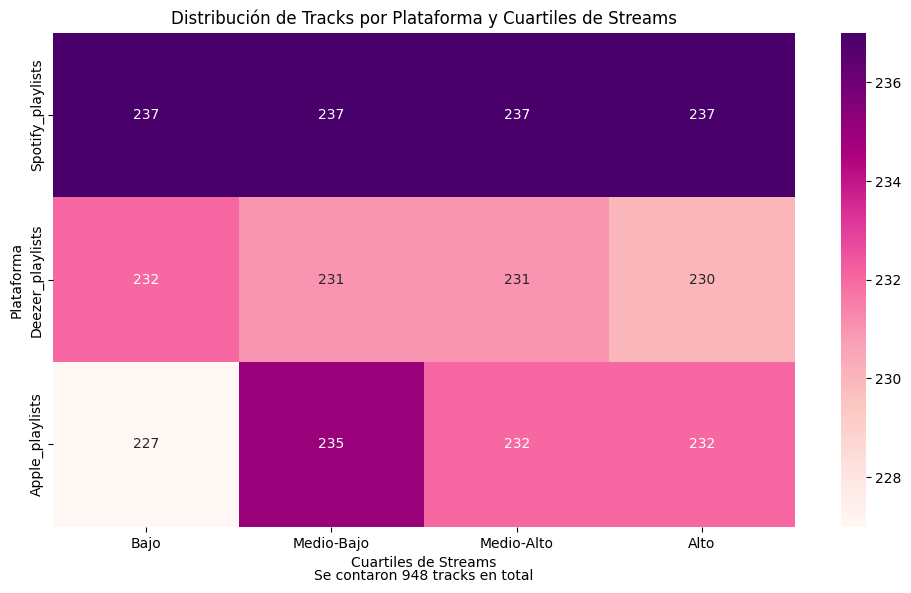

In [105]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Definir nombres y orden de cuartiles para streams y caracter√≠sticas
cuartiles_dict = {1: 'Bajo', 2: 'Medio-Bajo', 3: 'Medio-Alto', 4: 'Alto'}

# Funci√≥n para contar tracks por combinaci√≥n de cuartiles de streams y aparici√≥n en playlists
def count_tracks(df):
    heatmap_data = pd.DataFrame(index=['Spotify', 'Deezer', 'Apple'], columns=cuartiles_dict.values(), dtype=float)

    for cuartile, cuartile_name in cuartiles_dict.items():
        for platform in ['in_spotify_playlists', 'in_deezer_playlists', 'in_apple_playlists']:
            # Conteo de tracks que cumplen las condiciones especificadas
            counts = df[(df['cuartiles_streams'] == cuartile) &
                        (df[platform].notnull()) &
                        (df[platform] > 0)].shape[0]
            heatmap_data.loc[platform.replace('in_', '').capitalize(), cuartile_name] = counts

    return heatmap_data

# Llamada a la funci√≥n count_tracks
heatmap_data = count_tracks(df_cleaned)

# Eliminar filas que est√°n completamente vac√≠as
heatmap_data = heatmap_data.dropna(how='all')

# Crear el heatmap usando seaborn
plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, fmt=".0f", cmap="RdPu", cbar_kws={'format': '%.0f'})
plt.title('Distribuci√≥n de Tracks por Plataforma y Cuartiles de Streams')
plt.xlabel('Cuartiles de Streams')
plt.ylabel('Plataforma')

# Mostrar el conteo total de tracks en el DataFrame df_cleaned
plt.text(0.5, -0.1, f"Se contaron {df_cleaned.shape[0]} tracks en total",
         horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)

plt.tight_layout()
plt.savefig('heatmap_tracks_platforms.png', dpi=300)
plt.show()


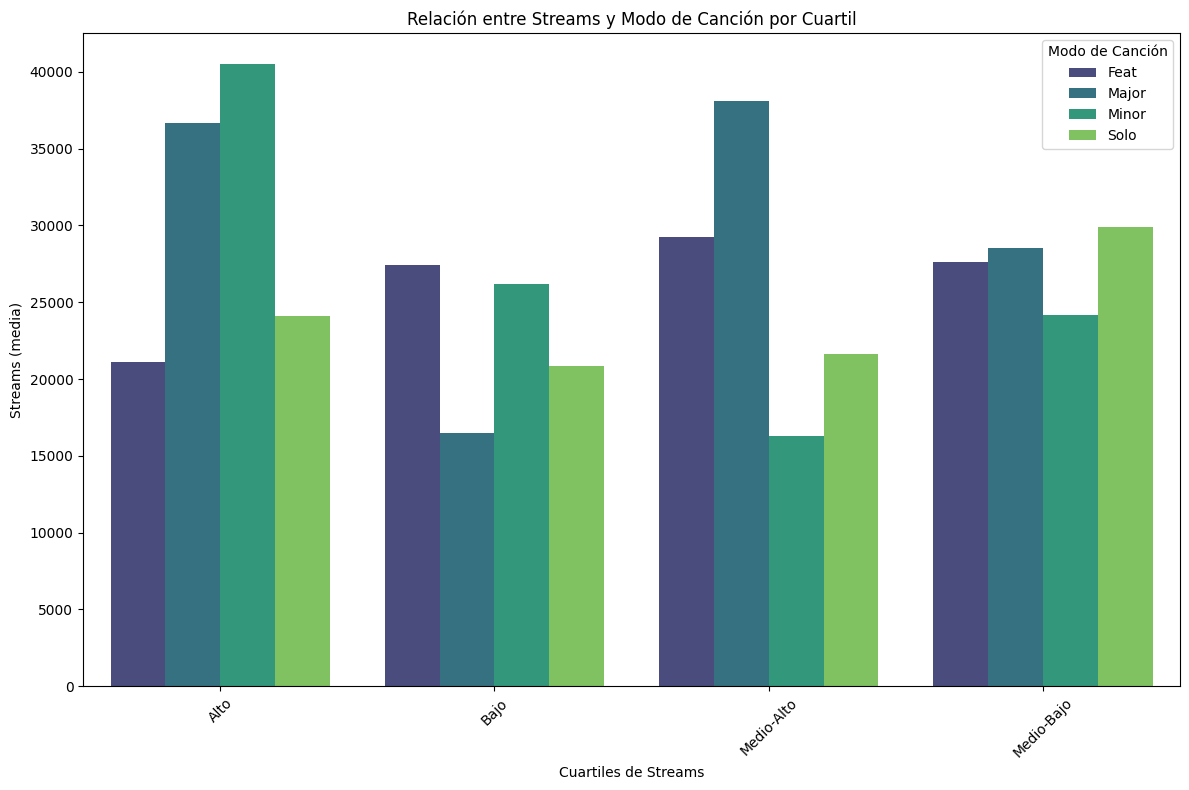

In [141]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind

# Ejemplo de DataFrame con datos ficticios
data = {
    'streams': np.random.randint(1000, 50000, 100),
    'cuartiles_streams': np.random.choice([1, 2, 3, 4], 100),
    'modo_cancion': np.random.choice(['Minor', 'Major', 'Feat', 'Solo'], 100)
}
df = pd.DataFrame(data)

# Definir nombres de cuartiles y modos de canci√≥n
cuartiles_dict = {4: 'Alto', 3: 'Medio-Alto', 2: 'Medio-Bajo', 1: 'Bajo'}
df['cuartiles_categoria'] = df['cuartiles_streams'].map(cuartiles_dict)

# Calcular medias de streams por cuartil y modo de canci√≥n
means = df.groupby(['cuartiles_categoria', 'modo_cancion'])['streams'].mean().reset_index()

# Configurar el tama√±o de la figura
plt.figure(figsize=(12, 8))

# Crear el gr√°fico de barras
sns.barplot(x='cuartiles_categoria', y='streams', hue='modo_cancion', data=means, palette='viridis')

# A√±adir detalles al gr√°fico
plt.title('Relaci√≥n entre Streams y Modo de Canci√≥n por Cuartil')
plt.xlabel('Cuartiles de Streams')
plt.ylabel('Streams (media)')
plt.xticks(rotation=45)
plt.legend(title='Modo de Canci√≥n')

# Mostrar el gr√°fico
plt.tight_layout()
plt.show()


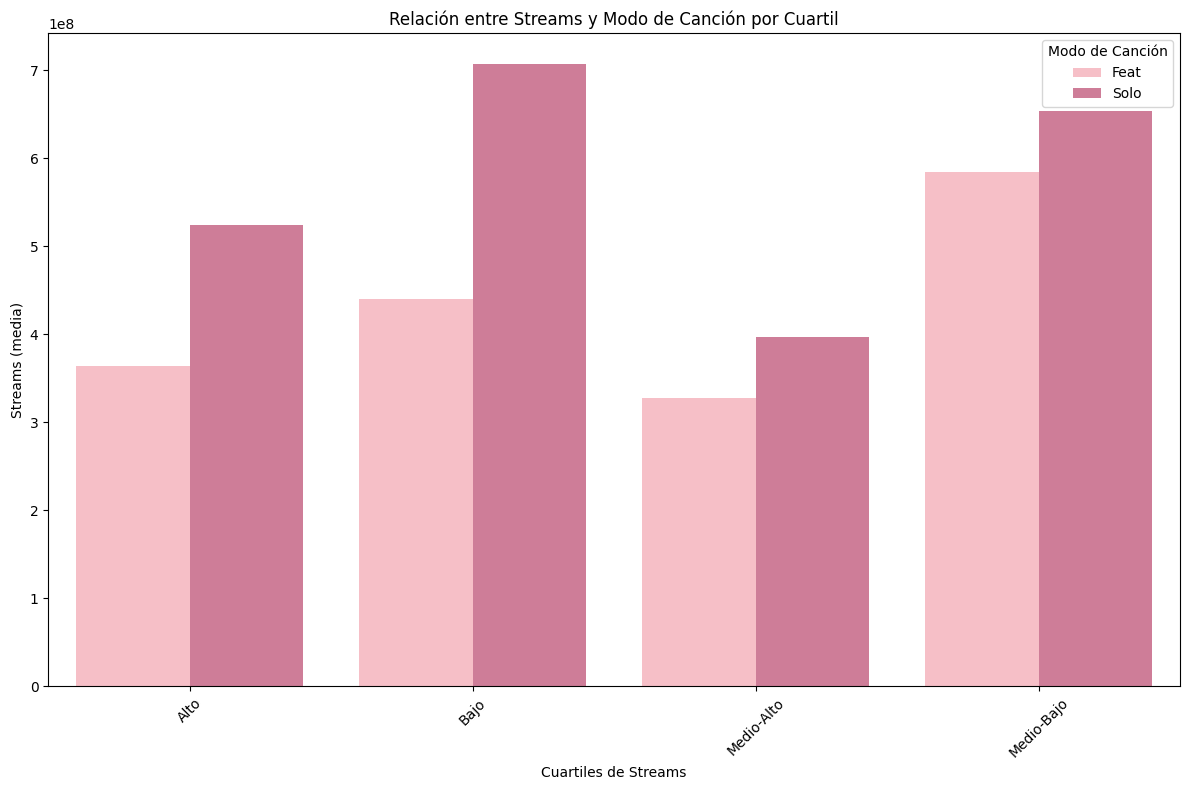

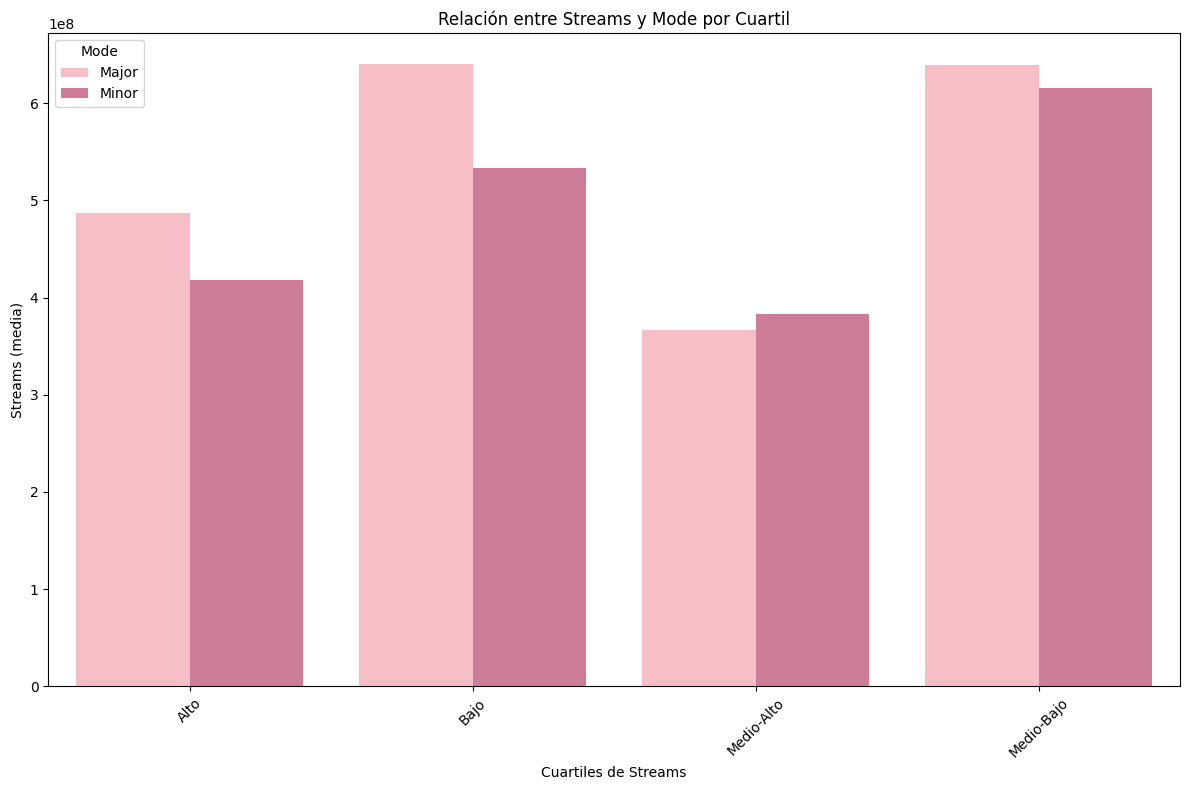

In [148]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import shapiro, ttest_ind, mannwhitneyu, pearsonr

# Definir nombres de cuartiles y modos de canci√≥n
cuartiles_dict = {4: 'Alto', 3: 'Medio-Alto', 2: 'Medio-Bajo', 1: 'Bajo'}
df_cleaned['cuartiles_categoria'] = df_cleaned['cuartiles_streams'].map(cuartiles_dict)

# Funci√≥n para realizar prueba Shapiro-Wilk
def test_shapiro(df, grupo, caracteristica):
    grupo_data = df[df['cuartiles_categoria'] == grupo][caracteristica]
    stat, p_value = shapiro(grupo_data)
    return p_value

# Funci√≥n para realizar prueba de t-test
def test_t(df, grupo1, grupo2, caracteristica):
    grupo1_data = df[df['cuartiles_categoria'] == grupo1][caracteristica]
    grupo2_data = df[df['cuartiles_categoria'] == grupo2][caracteristica]
    stat, p_value = ttest_ind(grupo1_data, grupo2_data, equal_var=False)
    return p_value

# Funci√≥n para realizar prueba de Wilcoxon-Mann-Whitney
def test_wilcoxon(df, grupo1, grupo2, caracteristica):
    grupo1_data = df[df['cuartiles_categoria'] == grupo1][caracteristica]
    grupo2_data = df[df['cuartiles_categoria'] == grupo2][caracteristica]
    stat, p_value = mannwhitneyu(grupo1_data, grupo2_data)
    return p_value

# Funci√≥n para calcular correlaci√≥n de Pearson
def test_pearson(df, grupo, caracteristica):
    grupo_data = df[df['cuartiles_categoria'] == grupo]
    correlation, p_value = pearsonr(grupo_data['streams'], grupo_data[caracteristica])
    return correlation, p_value

# Calcular medias de streams por cuartil y modo de canci√≥n
means_modo_cancion = df_cleaned.groupby(['cuartiles_categoria', 'modo_cancion'])['streams'].mean().reset_index()
means_mode = df_cleaned.groupby(['cuartiles_categoria', 'mode'])['streams'].mean().reset_index()

# Gr√°fico de barras para visualizar las medias por modo de canci√≥n
plt.figure(figsize=(12, 8))
sns.barplot(x='cuartiles_categoria', y='streams', hue='modo_cancion', data=means_modo_cancion, palette=['#FFB6C1', '#DB7093'])
plt.title('Relaci√≥n entre Streams y Modo de Canci√≥n por Cuartil')
plt.xlabel('Cuartiles de Streams')
plt.ylabel('Streams (media)')
plt.xticks(rotation=45)
plt.legend(title='Modo de Canci√≥n')
plt.tight_layout()
plt.show()

# Gr√°fico de barras para visualizar las medias por modo (Minor/Major)
plt.figure(figsize=(12, 8))
sns.barplot(x='cuartiles_categoria', y='streams', hue='mode', data=means_mode, palette=['#FFB6C1', '#DB7093'])
plt.title('Relaci√≥n entre Streams y Mode por Cuartil')
plt.xlabel('Cuartiles de Streams')
plt.ylabel('Streams (media)')
plt.xticks(rotation=45)
plt.legend(title='Mode')
plt.tight_layout()
plt.show()


In [157]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import squarify

# Definir los nombres de los cuartiles
cuartiles_dict = {4: 'Alto', 3: 'Medio-Alto', 2: 'Medio-Bajo', 1: 'Bajo'}
df_cleaned['cuartiles_categoria'] = df_cleaned['cuartiles_streams'].map(cuartiles_dict)

# Crear tablas pivot para los gr√°ficos
pivot_table_mode = df_cleaned.pivot_table(index='cuartiles_categoria', columns='mode', values='track_id', aggfunc='count', fill_value=0)
pivot_table_modocancion = df_cleaned.pivot_table(index='cuartiles_categoria', columns='modo_cancion', values='track_id', aggfunc='count', fill_value=0)

# Convertir las tablas pivot a formato adecuado para el gr√°fico
df_mode = pivot_table_mode.reset_index().melt(id_vars='cuartiles_categoria', var_name='mode', value_name='count')
df_modocancion = pivot_table_modocancion.reset_index().melt(id_vars='cuartiles_categoria', var_name='modo_cancion', value_name='count')

# Definir paletas de colores femeninos
palette_rosas = ['#FADBD8', '#F1948A', '#E5989B', '#F5B7B1', '#EC7063']  # Tonos de rosa suaves
palette_verdes = ['#D5F5E3', '#ABEBC6', '#82E0AA', '#58D68D', '#2ECC71']  # Tonos de verde suaves

# Configurar el tama√±o de la figura
plt.figure(figsize=(20, 10))

# Primer treemap para mode con paleta de rosas suaves
plt.subplot(1, 2, 1)
squarify.plot(sizes=df_mode['count'], label=df_mode['cuartiles_categoria'] + ' - ' + df_mode['mode'], alpha=.8, color=palette_rosas)
plt.title('Distribuci√≥n de Tracks por Mode y Cuartiles de Streams', fontsize=14)
plt.axis('off')

# Segundo treemap para modo de canci√≥n con paleta de verdes suaves
plt.subplot(1, 2, 2)
squarify.plot(sizes=df_modocancion['count'], label=df_modocancion['cuartiles_categoria'] + ' - ' + df_modocancion['modo_cancion'], alpha=.8, color=palette_verdes)
plt.title('Distribuci√≥n de Tracks por Modo de Canci√≥n y Cuartiles de Streams', fontsize=14)
plt.axis('off')

# Ajustar el espaciado y mostrar la figura
plt.tight_layout()
plt.show()


In [168]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import squarify

# Definir los nombres de los cuartiles
cuartiles_dict = {4: 'Alto', 3: 'Medio-Alto', 2: 'Medio-Bajo', 1: 'Bajo'}
df_cleaned['cuartiles_categoria'] = df_cleaned['cuartiles_streams'].map(cuartiles_dict)

# Crear tabla pivot para el gr√°fico combinado de mode y modo_cancion
pivot_table_combinado = df_cleaned.pivot_table(index=['cuartiles_categoria', 'mode'], columns='modo_cancion', values='track_id', aggfunc='count', fill_value=0)

# Convertir la tabla pivot a formato adecuado para el gr√°fico
df_combinado = pivot_table_combinado.reset_index().melt(id_vars=['cuartiles_categoria', 'mode'], var_name='modo_cancion', value_name='count')

# Ordenar los datos de manera personalizada para un treemap horizontal
orden_personalizado = ['Alto', 'Medio-Alto', 'Medio-Bajo', 'Bajo']
df_combinado['cuartiles_categoria'] = pd.Categorical(df_combinado['cuartiles_categoria'], categories=orden_personalizado, ordered=True)
df_combinado.sort_values(by=['cuartiles_categoria', 'count'], ascending=[True, False], inplace=True)

# Convertir cuartiles_categoria a tipo str para concatenar
df_combinado['cuartiles_categoria'] = df_combinado['cuartiles_categoria'].astype(str)

# Definir una paleta de colores seg√∫n las especificaciones
palette = ['#E9A1A5', '#BB8C79', '#A23B4D', '#373940']  # #E9A1A5, caf√© rosado, palo rosa oscuro, caf√© oscuro

# Configurar el tama√±o de la figura
plt.figure(figsize=(10, 10))

# Crear el treemap combinado para mode y modo_cancion
squarify.plot(sizes=df_combinado['count'], label=df_combinado['cuartiles_categoria'] + ' - ' + df_combinado['mode'] + ' - ' + df_combinado['modo_cancion'] + '\n' + df_combinado['count'].astype(str), alpha=.8, color=palette, text_kwargs={'fontsize':10})
plt.title('Distribuci√≥n de Tracks por Mode, Modo de Canci√≥n y Cuartiles de Streams', fontsize=14)
plt.axis('off')

# Ajustar el espaciado y mostrar la figura
plt.tight_layout()
plt.show()
